In [ ]:
# Install required packages.
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-cluster -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

2.8.0+cu126
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 56.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 26.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 23.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


# define  dataset tho

In [ ]:
import json
import os
import os.path as osp
from typing import Callable, List, Optional, Union

import torch

from torch_geometric.data import (
    Data,
    InMemoryDataset,
    download_url,
    extract_zip,
)
from torch_geometric.io import fs, read_txt_array


class BreakBad(InMemoryDataset):


    url = ('https://shapenet.cs.stanford.edu/media/'
           'shapenetcore_partanno_segmentation_benchmark_v0_normal.zip')

    # In case `shapenet.cs.stanford.edu` is offline, try to download the data
    # from Kaggle instead (requires login):
    # https://www.kaggle.com/datasets/mitkir/shapenet/download?datasetVersionNumber=1

    category_ids = {
        'Not_Solid_obj': 'not_solid',
        'Solid_obj': 'solid'
    }



    seg_classes = {
        'Not_Solid_obj': [0,1],
        'Solid_obj': [2,3]
    }

    def __init__(
        self,
        root: str,
        categories: Optional[Union[str, List[str]]] = None,
        include_normals: bool = True,
        split: str = 'trainval',
        transform: Optional[Callable] = None,
        pre_transform: Optional[Callable] = None,
        pre_filter: Optional[Callable] = None,
        force_reload: bool = False,
    ) -> None:
        if categories is None:
            categories = list(self.category_ids.keys())
        if isinstance(categories, str):
            categories = [categories]
        print(categories)
        assert all(category in self.category_ids for category in categories)
        self.categories = categories
        super().__init__(root, transform, pre_transform, pre_filter,
                         force_reload=force_reload)

        if split == 'train':
            path = self.processed_paths[0]
        elif split == 'val':
            path = self.processed_paths[1]
        elif split == 'test':
            path = self.processed_paths[2]
        elif split == 'trainval':
            path = self.processed_paths[3]
        else:
            raise ValueError(f'Split {split} found, but expected either '
                             'train, val, trainval or test')

        self.load(path)

        assert isinstance(self._data, Data)
        self._data.x = self._data.x if include_normals else None

        self.y_mask = torch.zeros((len(self.seg_classes.keys()),len(self.seg_classes.keys())*2),
                                  dtype=torch.bool)
        for i, labels in enumerate(self.seg_classes.values()):
            self.y_mask[i, labels] = 1

    @property
    def num_classes(self) -> int:
        return self.y_mask.size(-1)

    @property
    def raw_file_names(self) -> List[str]:
        return list(self.category_ids.values()) + ['train_test_split']

    @property
    def processed_file_names(self) -> List[str]:
        cats = '_'.join([cat[:3].lower() for cat in self.categories])
        return [
            osp.join(f'{cats}_{split}.pt')
            for split in ['train', 'val', 'test', 'trainval']
        ]

    def download(self) -> None:
        pass

    def process_filenames(self, filenames: List[str]) -> List[Data]:
        rank_ids = {
        'solid' : 1,
        'not_solid' : 0

        }
        data_list = []
        categories_ids = [self.category_ids[cat] for cat in self.categories]
        cat_idx = {categories_ids[i]: i for i in range(len(categories_ids))}

        for name in filenames:
            cat = name.split(osp.sep)[0]
            if cat not in categories_ids:
                continue
            my_custom_idx = rank_ids[cat]
            tensor = read_txt_array(osp.join(self.raw_dir, name))
            pos = tensor[:, :3]
            x = tensor[:, 3:6]
            y = tensor[:, -1].type(torch.long)
            data = Data(pos=pos, x=x, y=y, category=cat_idx[cat])
            if self.pre_filter is not None and not self.pre_filter(data):
                continue
            if self.pre_transform is not None:
                data = self.pre_transform(data)
            data_list.append(data)

        return data_list

    def process(self) -> None:
        trainval = []
        for i, split in enumerate(['train', 'val', 'test']):
            path = osp.join(self.raw_dir, 'train_test_split',
                            f'shuffled_{split}_file_list.json')
            with open(path) as f:
                filenames = [
                    osp.sep.join(name.split('/')[1:]) + '.txt'
                    for name in json.load(f)
                ]  # Removing first directory.
            data_list = self.process_filenames(filenames)
            if split == 'train' or split == 'val':
                trainval += data_list
            self.save(data_list, self.processed_paths[i])
        self.save(trainval, self.processed_paths[3])

    def __repr__(self) -> str:
        return (f'{self.__class__.__name__}({len(self)}, '
                f'categories={self.categories})')


In [ ]:
import torch.nn.functional as F
from torch_geometric.nn import MLP, DynamicEdgeConv


import torch_geometric.transforms as T
from torch_geometric.datasets import ShapeNet
from torch_geometric.loader import DataLoader
from torch_geometric.nn import MLP, knn_interpolate
from torch_geometric.typing import WITH_TORCH_CLUSTER
from torch_geometric.utils import scatter


In [ ]:
!rm -r /content/data

In [ ]:
!unzip /content/solid_all_class.zip -d /content/temp_extract
!mkdir /content/data
!mkdir /content/data/raw
!mv /content/temp_extract/solid_all_class/* /content/data/raw
!rm -r /content/temp_extract

Archive:  /content/solid_all_class.zip
   creating: /content/temp_extract/solid_all_class/
   creating: /content/temp_extract/solid_all_class/not_solid/
  inflating: /content/temp_extract/solid_all_class/not_solid/101902_sf_piece_0_fractured_22.txt  
  inflating: /content/temp_extract/solid_all_class/not_solid/101902_sf_piece_0_fractured_41.txt  
  inflating: /content/temp_extract/solid_all_class/not_solid/101902_sf_piece_0_fractured_59.txt  
  inflating: /content/temp_extract/solid_all_class/not_solid/101902_sf_piece_0_fractured_70.txt  
  inflating: /content/temp_extract/solid_all_class/not_solid/101902_sf_piece_0_fractured_72.txt  
  inflating: /content/temp_extract/solid_all_class/not_solid/101902_sf_piece_0_fractured_75.txt  
  inflating: /content/temp_extract/solid_all_class/not_solid/101902_sf_piece_0_fractured_76.txt  
  inflating: /content/temp_extract/solid_all_class/not_solid/101902_sf_piece_0_mode_11.txt  
  inflating: /content/temp_extract/solid_all_class/not_solid/101902_

In [ ]:
category = 'Not_Solid_obj'  # Pass in `None` to train on all categories.
path = "/content/data"
transform = T.Compose([
    T.RandomJitter(0.01),
    T.RandomRotate(15, axis=0),
    T.RandomRotate(15, axis=1),
    T.RandomRotate(15, axis=2)
])
pre_transform = T.NormalizeScale()
train_dataset = BreakBad(path, category, split='trainval', transform=transform,
                         pre_transform=pre_transform)
test_dataset = BreakBad(path, category, split='test',
                        pre_transform=pre_transform)
train_loader = DataLoader(train_dataset, batch_size=12, shuffle=True,
                          num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=12, shuffle=False,
                         num_workers=2)

['Not_Solid_obj']


Processing...


['Not_Solid_obj']


Done!


In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Needed for 3D plotting
import torch
import random
import numpy as np

gt_cmap = np.array([
    [0.121, 0.466, 0.705],  # Blue for class 0
    [1.000, 0.498, 0.054],  # Orange for class 1
])

@torch.no_grad()
def visualize_ground_truth_3d(loader, num_samples=4):
    # Load all data samples into a list for random access
    all_data = list(loader)

    sampled_data = random.sample(all_data, min(num_samples, len(all_data)))
    sample_id = 1

    for data in sampled_data:
        data = data.to(device)

        sizes = (data.ptr[1:] - data.ptr[:-1]).tolist()
        xs = data.pos.split(sizes)
        ys = data.y.split(sizes)

        for x, y in zip(xs, ys):
            x_np = x.cpu().numpy()
            y_np = y.cpu().numpy()

            # Convert y labels to RGB colors using gt_cmap
            colors = gt_cmap[y_np%2]
            print(f"Unique classes {np.unique(y_np)}")
            fig = plt.figure(figsize=(6, 5))
            ax = fig.add_subplot(111, projection='3d')
            ax.scatter(x_np[:, 0], x_np[:, 1], x_np[:, 2], c=colors, s=5)
            ax.set_title(f'Ground Truth - Sample {sample_id}')
            ax.set_axis_off()
            plt.tight_layout()
            plt.show()

            sample_id += 1
            if sample_id > num_samples:
                return


Unique classes [0 1]


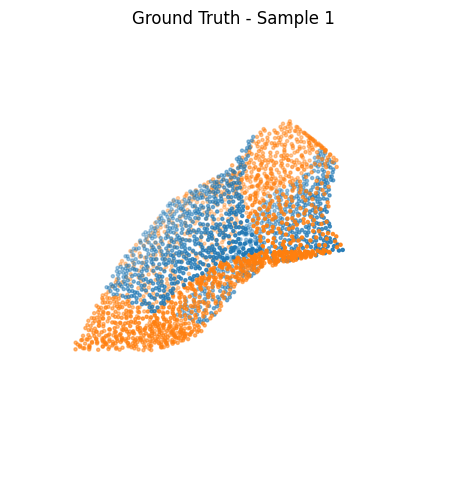

Unique classes [0 1]


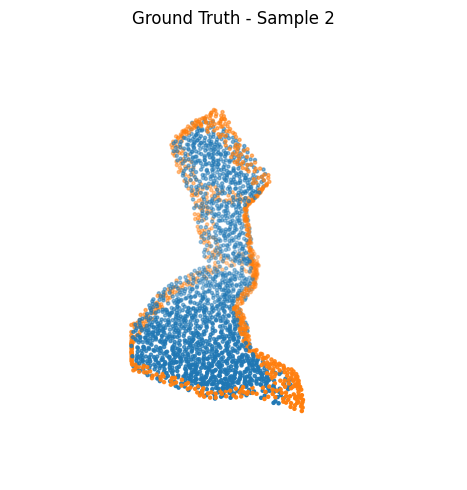

Unique classes [0 1]


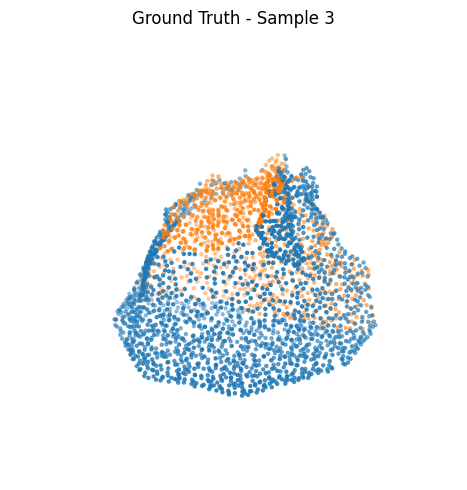

Unique classes [0 1]


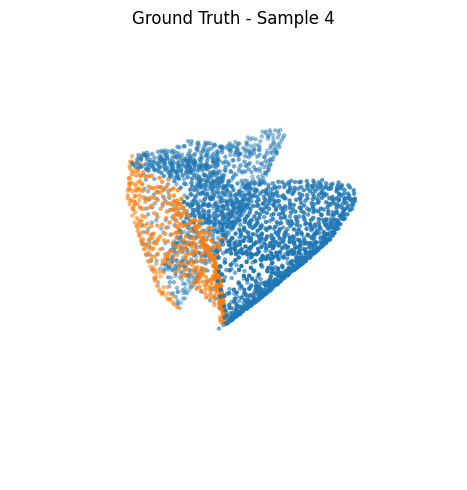

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
visualize_ground_truth_3d(test_loader, num_samples=4)

In [ ]:
from collections import Counter

# Count class frequencies
class_counts = Counter(train_dataset.data.y.tolist())
num_classes = 2
print(class_counts.most_common(2))
print(class_counts[2])
total = sum(class_counts.values())

# Inverse frequency (or other schemes, e.g., sqrt)
weights = torch.zeros(num_classes, dtype=torch.float)
for i in range(num_classes):
    weights[i] = total / (num_classes * class_counts.get(i, 1))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
weights = weights.to(device)
print(weights)

/tmp/ipython-input-4188088979.py:4: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  class_counts = Counter(train_dataset.data.y.tolist())


[(0, 1746866), (1, 1075419)]
0
tensor([0.8078, 1.3122], device='cuda:0')


# DGCNN


In [ ]:
class Net(torch.nn.Module):
    def __init__(self, out_channels, k=30, aggr='max'):
        super().__init__()

        self.conv1 = DynamicEdgeConv(MLP([2 * 6, 64, 64]), k, aggr)
        self.conv2 = DynamicEdgeConv(MLP([2 * 64, 64, 64]), k, aggr)
        self.conv3 = DynamicEdgeConv(MLP([2 * 64, 64, 64]), k, aggr)
        self.conv4 = DynamicEdgeConv(MLP([2 * 64, 64, 64]), k, aggr)  

      
        self.mlp = MLP([4 * 64, 1024, 256, 128, out_channels], dropout=0.5,
                       norm=None)

    def forward(self, data):
        x, pos, batch = data.x, data.pos, data.batch
        x0 = torch.cat([x, pos], dim=-1)
        x1 = self.conv1(x0, batch)
        x2 = self.conv2(x1, batch)
        x3 = self.conv3(x2, batch)
        x4 = self.conv4(x3, batch)  
        out = self.mlp(torch.cat([x1, x2, x3, x4], dim=1))
        return F.log_softmax(out, dim=1)

In [ ]:
def jaccard_index(pred: torch.Tensor, target: torch.Tensor, num_classes: int, absent_score: float = 1.0) -> float:
    """
    Compute mean Intersection over Union (IoU) between predicted and target labels.

    Args:
        pred (Tensor): Predicted labels (1D tensor of shape [N]).
        target (Tensor): Ground truth labels (1D tensor of shape [N]).
        num_classes (int): Number of classes to consider (usually the number of part labels for a category).
        absent_score (float): Score to assign if a class is absent in both pred and target.

    Returns:
        float: Mean IoU over classes.
    """
    device = pred.device
    ious = []

    for cls in range(num_classes):
        pred_inds = (pred == cls)
        target_inds = (target == cls)

        intersection = (pred_inds & target_inds).sum()
        union = (pred_inds | target_inds).sum()

        if union == 0:
            iou = torch.tensor(absent_score, device=device)
        else:
            iou = intersection.float() / union.float()
        ious.append(iou)

    # Stack and compute mean
    return torch.stack(ious).mean().item()

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net(2, k=30).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.002)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.8)


In [ ]:


import matplotlib.pyplot as plt

def train():
    model.train()
    loss_list = []
    acc_list = []
    total_loss = correct_nodes = total_nodes = 0
    for i, data in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data)
        loss = F.nll_loss(out, data.y,weight=weights)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        correct_nodes += out.argmax(dim=1).eq(data.y).sum().item()
        total_nodes += data.num_nodes

        if (i + 1) % 10 == 0:
            tloss = total_loss / 10
            tacc = correct_nodes / total_nodes
            print(f'[{i+1}/{len(train_loader)}] Loss: {tloss:.4f} '
                  f'Train Acc: {tacc:.4f}')
            total_loss = correct_nodes = total_nodes = 0
            loss_list.append(tloss)
            acc_list.append(tacc)

    return np.mean(loss_list), np.mean(acc_list)

@torch.no_grad()
def test(loader):
    model.eval()

    ious, categories = [], []
    y_map = torch.empty(loader.dataset.num_classes, device=device).long()
    for data in loader:
        data = data.to(device)
        outs = model(data)

        sizes = (data.ptr[1:] - data.ptr[:-1]).tolist()
        for out, y, category in zip(outs.split(sizes), data.y.split(sizes),
                                    data.category.tolist()):
            category = list(BreakBad.seg_classes.keys())[category]
            part = BreakBad.seg_classes[category]
            part = torch.tensor(part, device=device)

            y_map[part] = torch.arange(part.size(0), device=device)


            iou = jaccard_index(out[:, part].argmax(dim=-1), y_map[y],
                                num_classes=part.size(0), absent_score=1.0)
            ious.append(iou)
        categories.append(data.category)

    iou = torch.tensor(ious, device=device)
    category = torch.cat(categories, dim=0)

    mean_iou = scatter(iou, category, reduce='mean')  # Per-category IoU.
    return float(mean_iou.mean())  # Global IoU.

def plot_iou_over_epochs(iou_list):
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, len(iou_list) + 1), iou_list, marker='o', color='dodgerblue')
    plt.title('IoU over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Test IoU')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


def plot_loss_over_epochs(iou_list):
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, len(iou_list) + 1), iou_list, marker='o', color='orange')
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Train Loss')
    plt.grid(True)
    plt.tight_layout()
    plt.show()





[10/95] Loss: 0.6959 Train Acc: 0.4443
[20/95] Loss: 0.6645 Train Acc: 0.5531
[30/95] Loss: 0.6982 Train Acc: 0.4134
[40/95] Loss: 0.6794 Train Acc: 0.4668
[50/95] Loss: 0.6535 Train Acc: 0.5695
[60/95] Loss: 0.6163 Train Acc: 0.6558
[70/95] Loss: 0.5711 Train Acc: 0.6993
[80/95] Loss: 0.5140 Train Acc: 0.7169
[90/95] Loss: 0.5194 Train Acc: 0.7407
Epoch: 01, Test IoU: 0.5392


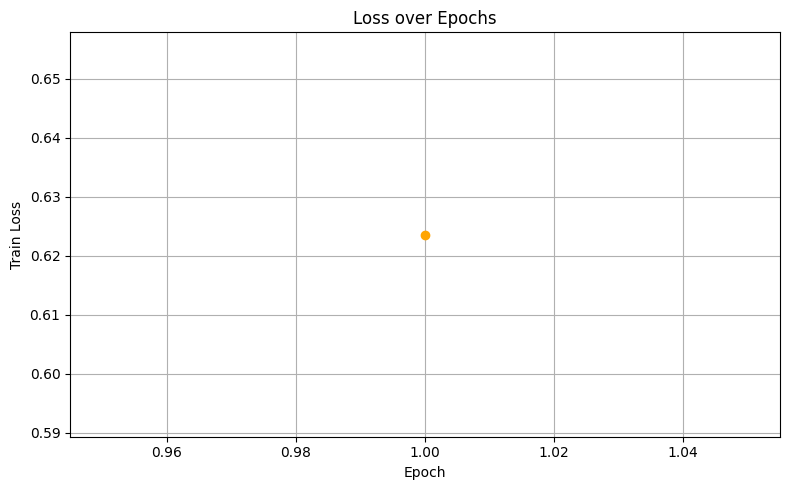

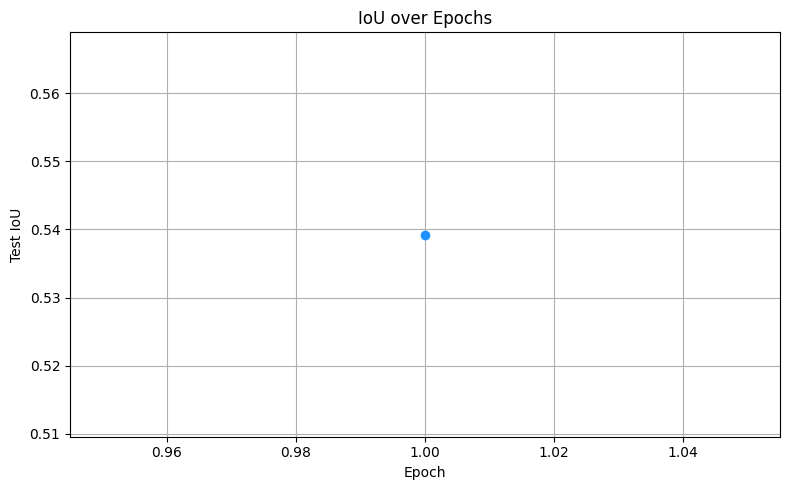

  >> Best model saved at epoch 1 with IoU: 0.5392
[10/95] Loss: 0.4986 Train Acc: 0.7566
[20/95] Loss: 0.4631 Train Acc: 0.7975
[30/95] Loss: 0.4613 Train Acc: 0.8100
[40/95] Loss: 0.4118 Train Acc: 0.8082
[50/95] Loss: 0.4570 Train Acc: 0.8140
[60/95] Loss: 0.4240 Train Acc: 0.8007
[70/95] Loss: 0.3718 Train Acc: 0.8420
[80/95] Loss: 0.3570 Train Acc: 0.8532
[90/95] Loss: 0.3255 Train Acc: 0.8621
Epoch: 02, Test IoU: 0.7184


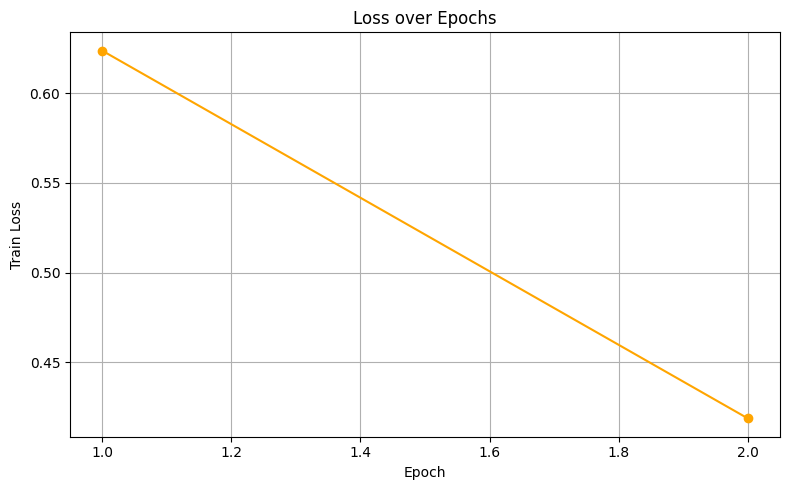

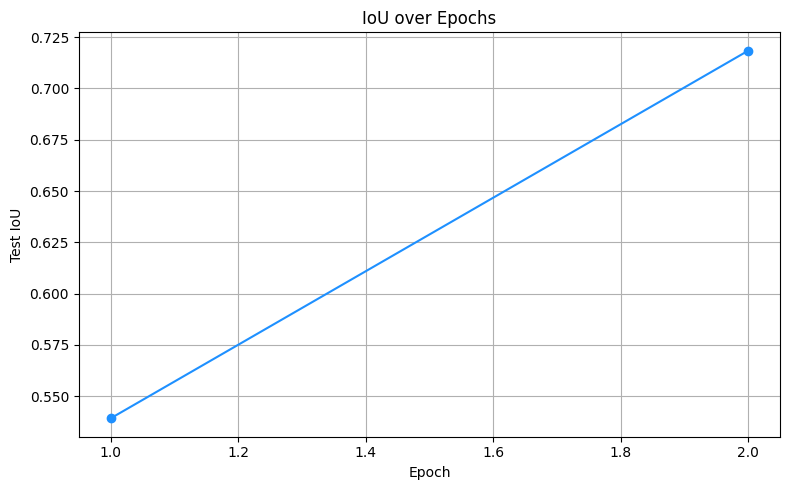

  >> Best model saved at epoch 2 with IoU: 0.7184
[10/95] Loss: 0.4853 Train Acc: 0.7875
[20/95] Loss: 0.4425 Train Acc: 0.7863
[30/95] Loss: 0.3483 Train Acc: 0.8432
[40/95] Loss: 0.4106 Train Acc: 0.8280
[50/95] Loss: 0.3635 Train Acc: 0.8539
[60/95] Loss: 0.3828 Train Acc: 0.8308
[70/95] Loss: 0.3348 Train Acc: 0.8724
[80/95] Loss: 0.3196 Train Acc: 0.8696
[90/95] Loss: 0.3002 Train Acc: 0.8754
Epoch: 03, Test IoU: 0.7686


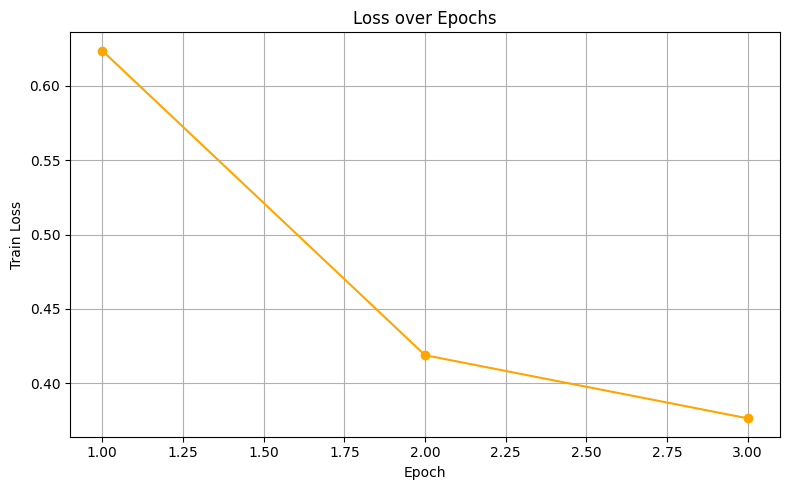

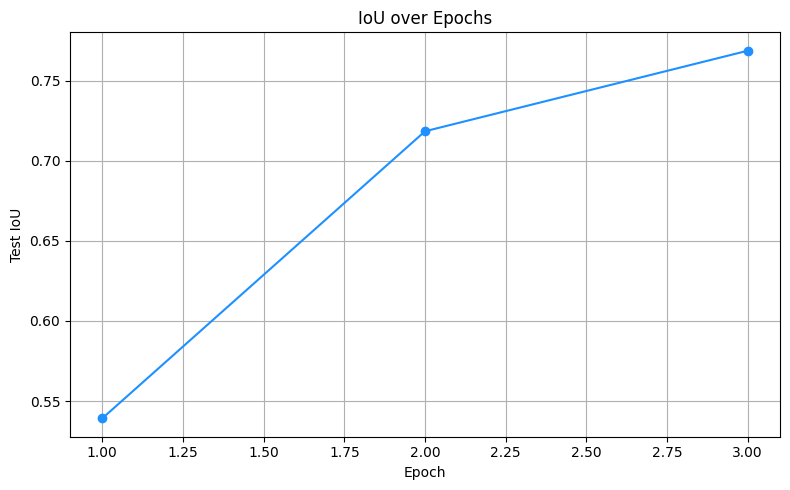

  >> Best model saved at epoch 3 with IoU: 0.7686
[10/95] Loss: 0.3373 Train Acc: 0.8534
[20/95] Loss: 0.3503 Train Acc: 0.8531
[30/95] Loss: 0.3346 Train Acc: 0.8641
[40/95] Loss: 0.3093 Train Acc: 0.8726
[50/95] Loss: 0.3367 Train Acc: 0.8749
[60/95] Loss: 0.3158 Train Acc: 0.8772
[70/95] Loss: 0.3344 Train Acc: 0.8612
[80/95] Loss: 0.2958 Train Acc: 0.8864
[90/95] Loss: 0.3463 Train Acc: 0.8527
Epoch: 04, Test IoU: 0.7808


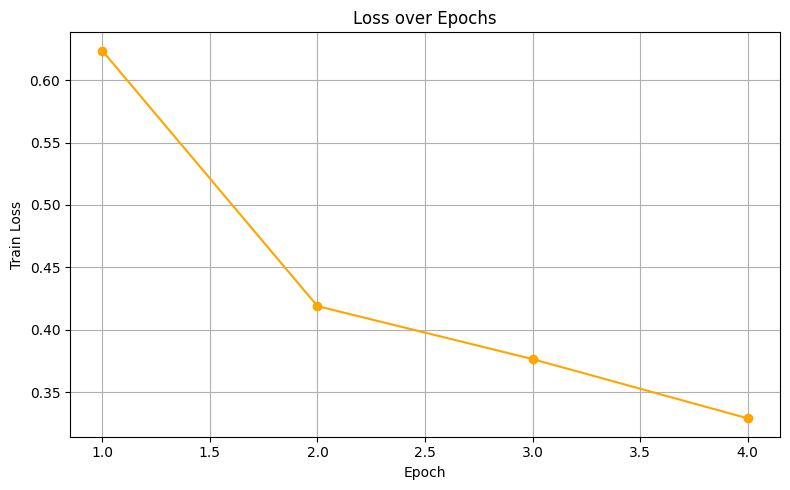

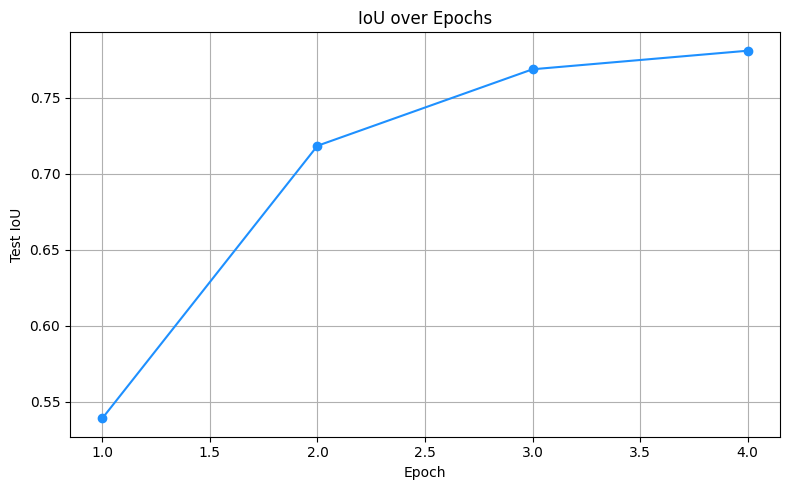

  >> Best model saved at epoch 4 with IoU: 0.7808
[10/95] Loss: 0.3009 Train Acc: 0.8919
[20/95] Loss: 0.2904 Train Acc: 0.8785
[30/95] Loss: 0.2645 Train Acc: 0.8947
[40/95] Loss: 0.2731 Train Acc: 0.8928
[50/95] Loss: 0.2528 Train Acc: 0.9007
[60/95] Loss: 0.2593 Train Acc: 0.9015
[70/95] Loss: 0.2579 Train Acc: 0.8990
[80/95] Loss: 0.2527 Train Acc: 0.8992
[90/95] Loss: 0.2685 Train Acc: 0.8990
Epoch: 05, Test IoU: 0.7568


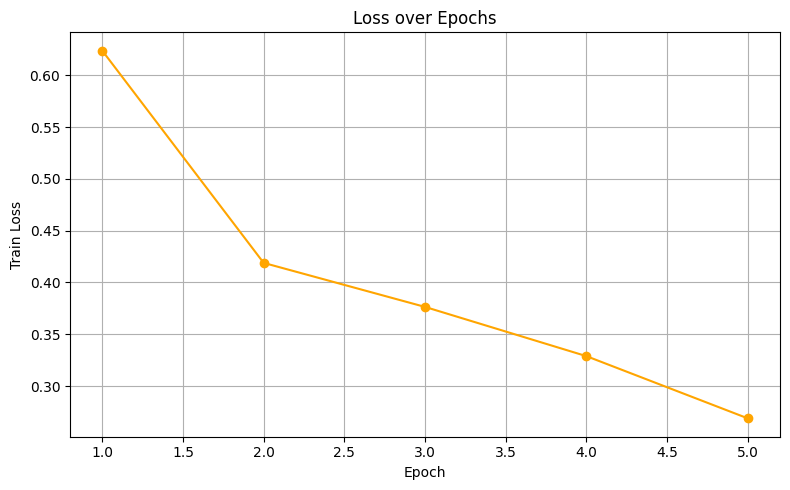

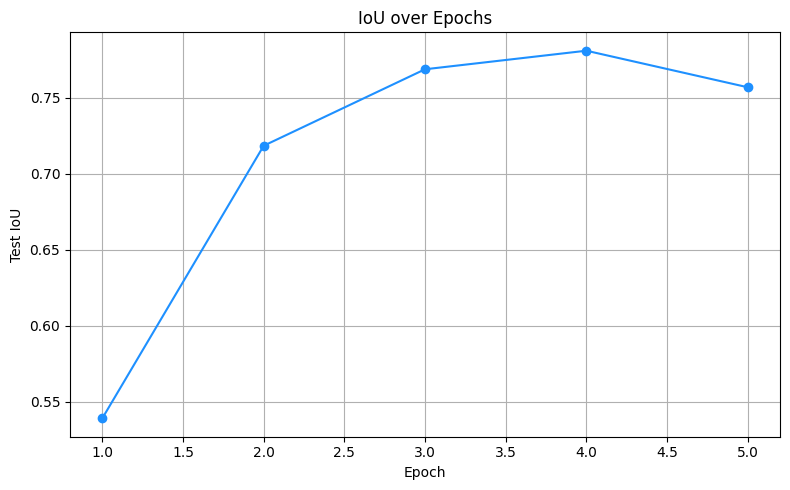

[10/95] Loss: 0.2801 Train Acc: 0.8874
[20/95] Loss: 0.2762 Train Acc: 0.8951
[30/95] Loss: 0.2311 Train Acc: 0.9155
[40/95] Loss: 0.2581 Train Acc: 0.9032
[50/95] Loss: 0.2396 Train Acc: 0.9080
[60/95] Loss: 0.2452 Train Acc: 0.9053
[70/95] Loss: 0.2132 Train Acc: 0.9159
[80/95] Loss: 0.2101 Train Acc: 0.9207
[90/95] Loss: 0.2291 Train Acc: 0.9091
Epoch: 06, Test IoU: 0.8314


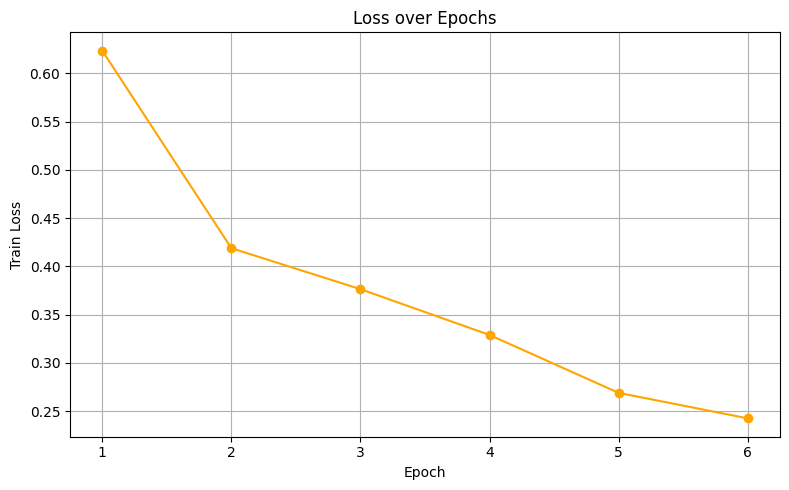

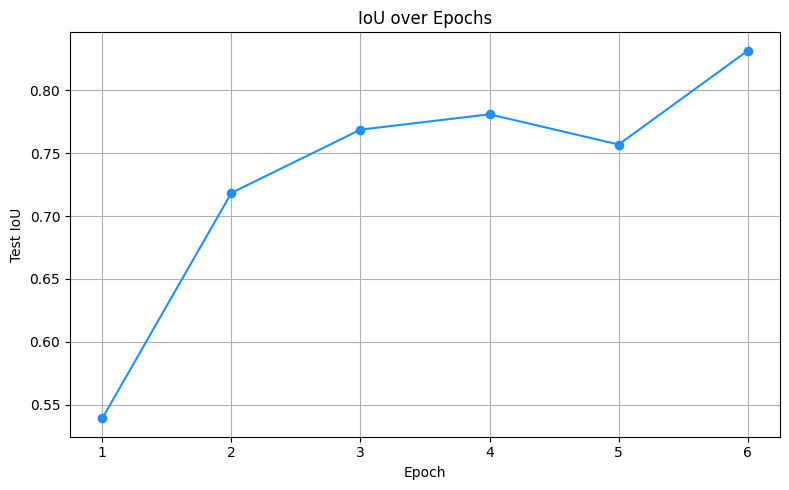

  >> Best model saved at epoch 6 with IoU: 0.8314
[10/95] Loss: 0.2789 Train Acc: 0.8817
[20/95] Loss: 0.2587 Train Acc: 0.8892
[30/95] Loss: 0.2191 Train Acc: 0.9092
[40/95] Loss: 0.2224 Train Acc: 0.9209
[50/95] Loss: 0.2250 Train Acc: 0.9151
[60/95] Loss: 0.2249 Train Acc: 0.9203
[70/95] Loss: 0.1909 Train Acc: 0.9264
[80/95] Loss: 0.2310 Train Acc: 0.9112
[90/95] Loss: 0.2370 Train Acc: 0.9110
Epoch: 07, Test IoU: 0.8178


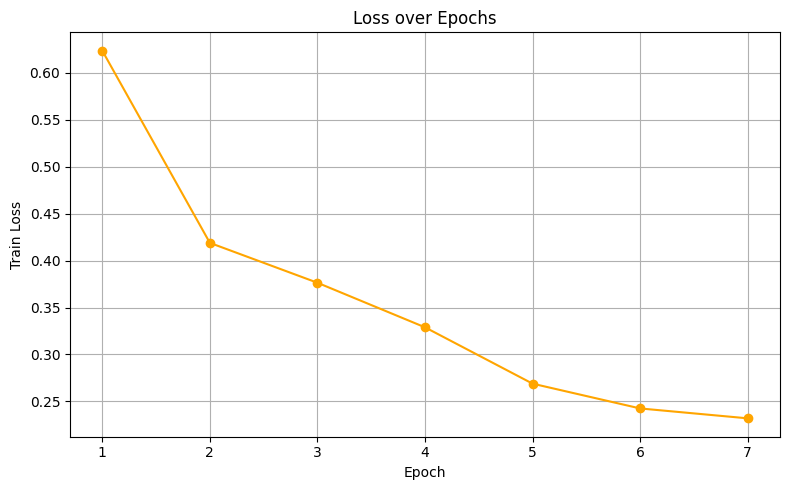

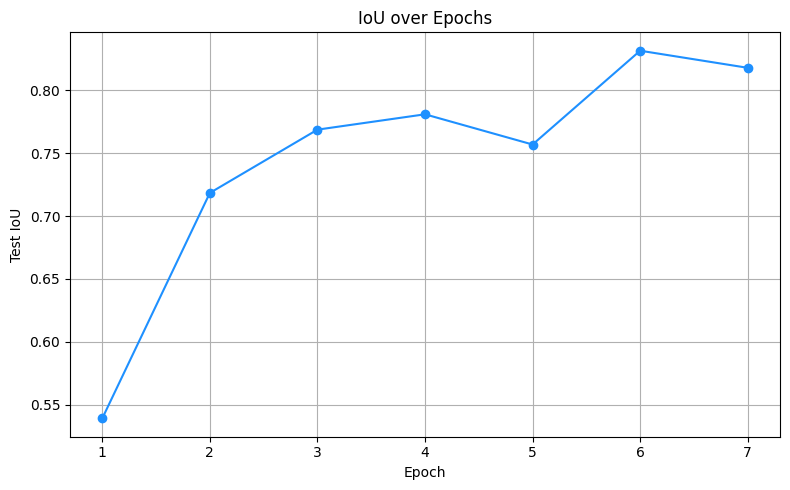

[10/95] Loss: 0.2659 Train Acc: 0.9057
[20/95] Loss: 0.2845 Train Acc: 0.8684
[30/95] Loss: 0.2306 Train Acc: 0.9143
[40/95] Loss: 0.2071 Train Acc: 0.9212
[50/95] Loss: 0.2003 Train Acc: 0.9278
[60/95] Loss: 0.1663 Train Acc: 0.9418
[70/95] Loss: 0.1976 Train Acc: 0.9224
[80/95] Loss: 0.2041 Train Acc: 0.9212
[90/95] Loss: 0.2118 Train Acc: 0.9151
Epoch: 08, Test IoU: 0.8093


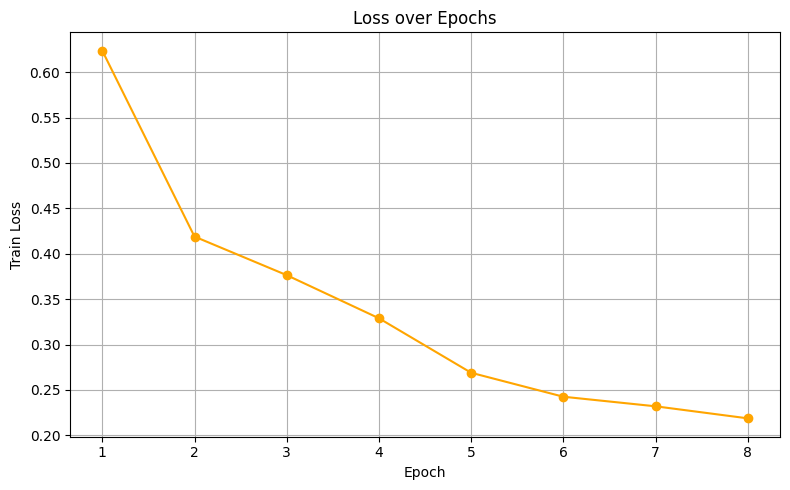

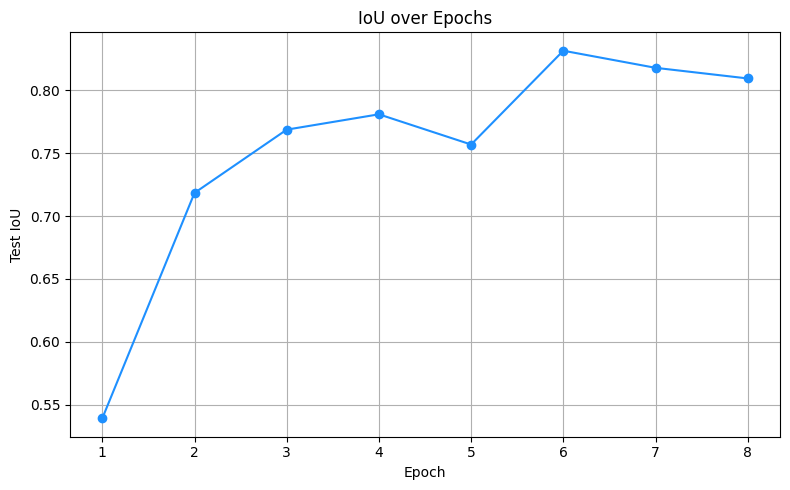

[10/95] Loss: 0.3362 Train Acc: 0.8596
[20/95] Loss: 0.2521 Train Acc: 0.9063
[30/95] Loss: 0.2119 Train Acc: 0.9193
[40/95] Loss: 0.1970 Train Acc: 0.9273
[50/95] Loss: 0.1930 Train Acc: 0.9278
[60/95] Loss: 0.1987 Train Acc: 0.9252
[70/95] Loss: 0.1644 Train Acc: 0.9436
[80/95] Loss: 0.1633 Train Acc: 0.9403
[90/95] Loss: 0.1868 Train Acc: 0.9317
Epoch: 09, Test IoU: 0.8545


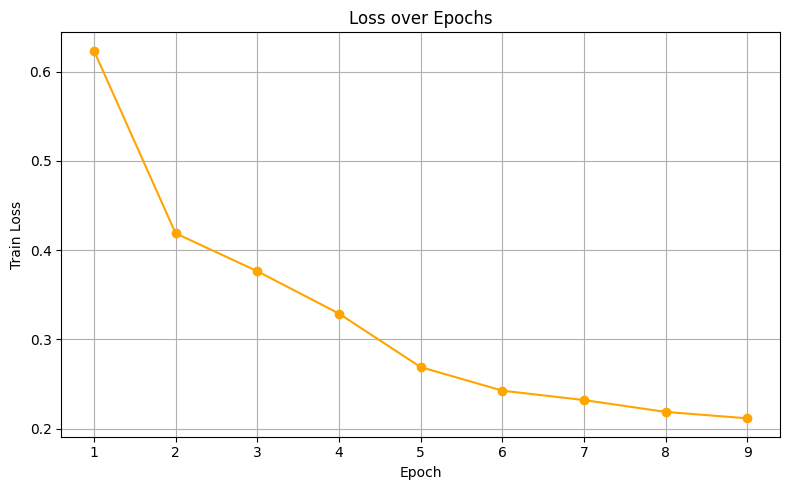

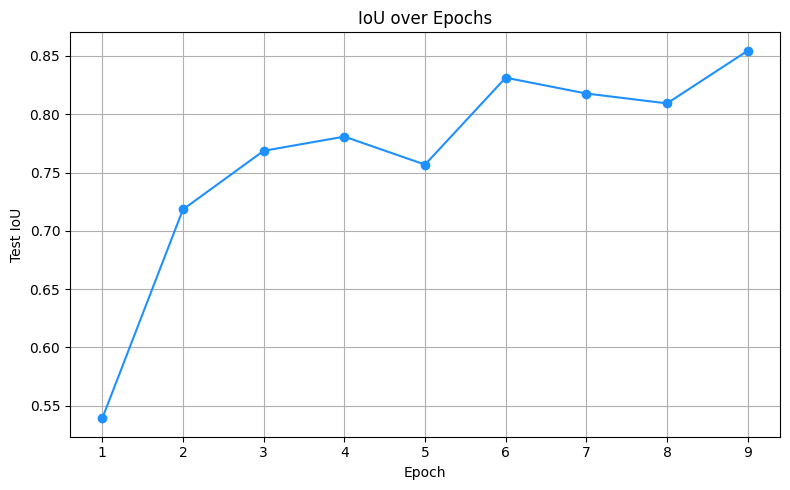

  >> Best model saved at epoch 9 with IoU: 0.8545
[10/95] Loss: 0.1823 Train Acc: 0.9356
[20/95] Loss: 0.1614 Train Acc: 0.9416
[30/95] Loss: 0.1789 Train Acc: 0.9376
[40/95] Loss: 0.1862 Train Acc: 0.9275
[50/95] Loss: 0.1719 Train Acc: 0.9377
[60/95] Loss: 0.2064 Train Acc: 0.9272
[70/95] Loss: 0.2118 Train Acc: 0.9179
[80/95] Loss: 0.1766 Train Acc: 0.9371
[90/95] Loss: 0.1667 Train Acc: 0.9394
Epoch: 10, Test IoU: 0.8538


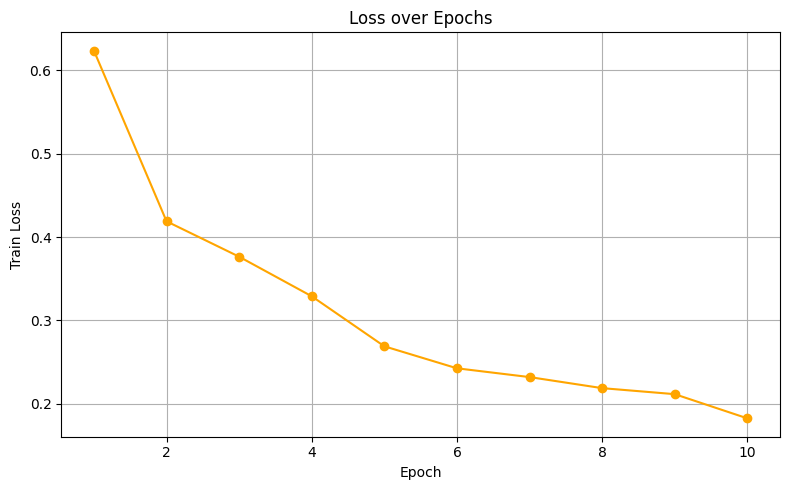

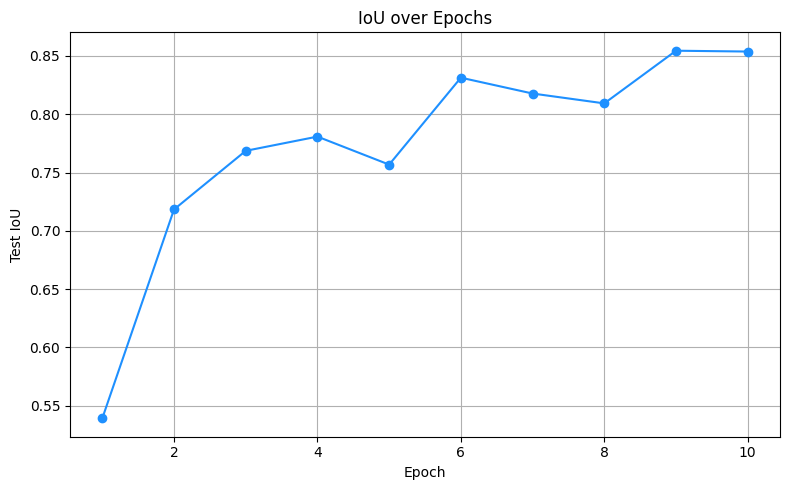

[10/95] Loss: 0.1630 Train Acc: 0.9412
[20/95] Loss: 0.1682 Train Acc: 0.9370
[30/95] Loss: 0.1523 Train Acc: 0.9532
[40/95] Loss: 0.1788 Train Acc: 0.9372
[50/95] Loss: 0.1611 Train Acc: 0.9418
[60/95] Loss: 0.1718 Train Acc: 0.9382
[70/95] Loss: 0.1516 Train Acc: 0.9419
[80/95] Loss: 0.1636 Train Acc: 0.9398
[90/95] Loss: 0.1466 Train Acc: 0.9481
Epoch: 11, Test IoU: 0.8580


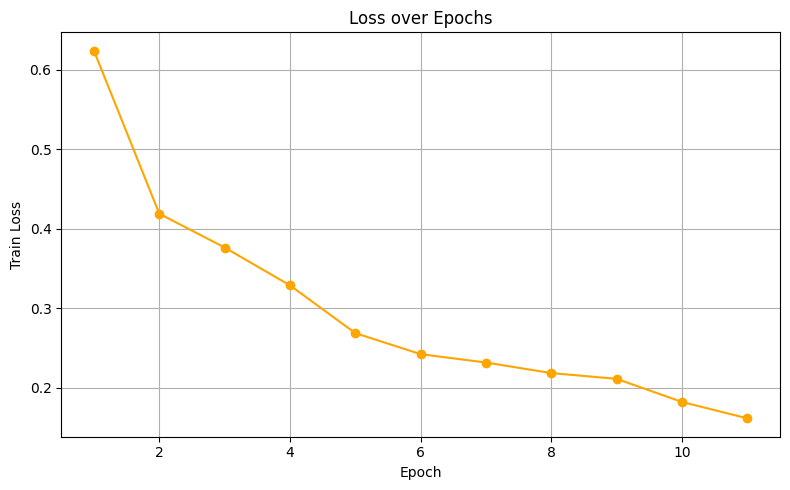

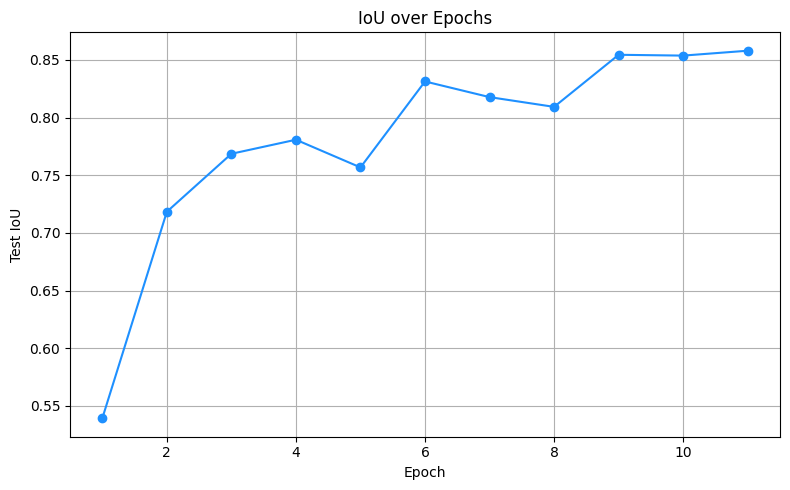

  >> Best model saved at epoch 11 with IoU: 0.8580
[10/95] Loss: 0.1582 Train Acc: 0.9420
[20/95] Loss: 0.1417 Train Acc: 0.9500
[30/95] Loss: 0.1333 Train Acc: 0.9523
[40/95] Loss: 0.1407 Train Acc: 0.9514
[50/95] Loss: 0.1312 Train Acc: 0.9539
[60/95] Loss: 0.1324 Train Acc: 0.9558
[70/95] Loss: 0.1523 Train Acc: 0.9455
[80/95] Loss: 0.1456 Train Acc: 0.9434
[90/95] Loss: 0.1407 Train Acc: 0.9519
Epoch: 12, Test IoU: 0.8640


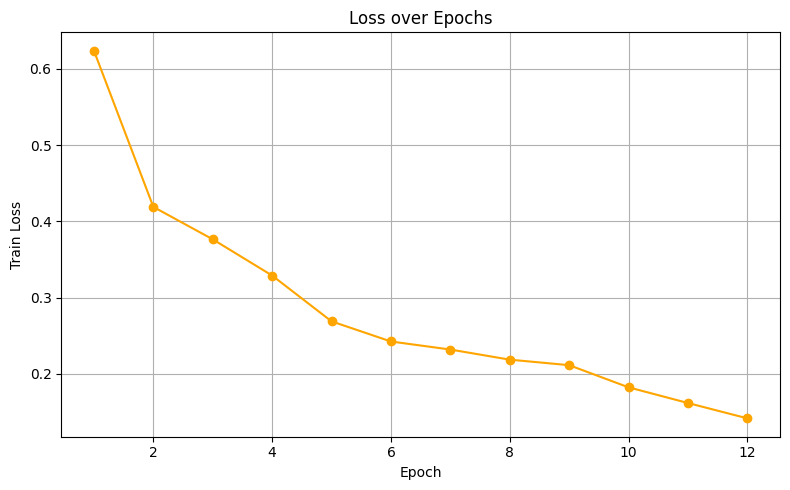

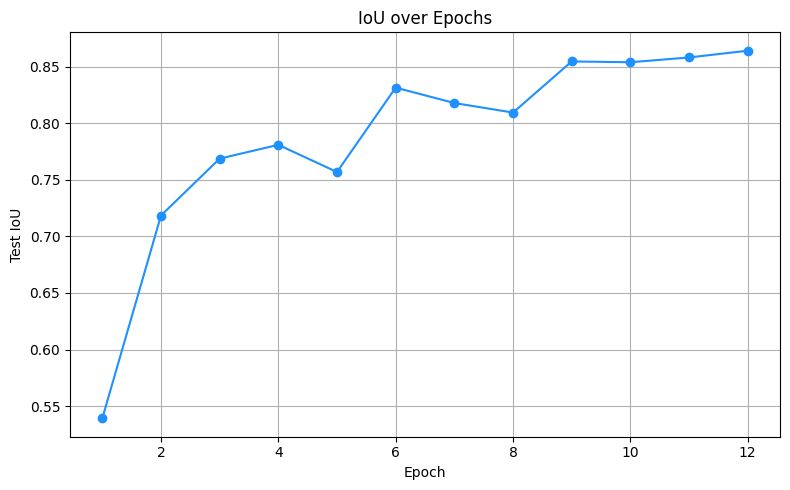

  >> Best model saved at epoch 12 with IoU: 0.8640
[10/95] Loss: 0.1719 Train Acc: 0.9391
[20/95] Loss: 0.1663 Train Acc: 0.9408
[30/95] Loss: 0.1683 Train Acc: 0.9420
[40/95] Loss: 0.1650 Train Acc: 0.9370
[50/95] Loss: 0.1362 Train Acc: 0.9519
[60/95] Loss: 0.1260 Train Acc: 0.9572
[70/95] Loss: 0.1270 Train Acc: 0.9547
[80/95] Loss: 0.1447 Train Acc: 0.9480
[90/95] Loss: 0.1211 Train Acc: 0.9602
Epoch: 13, Test IoU: 0.8895


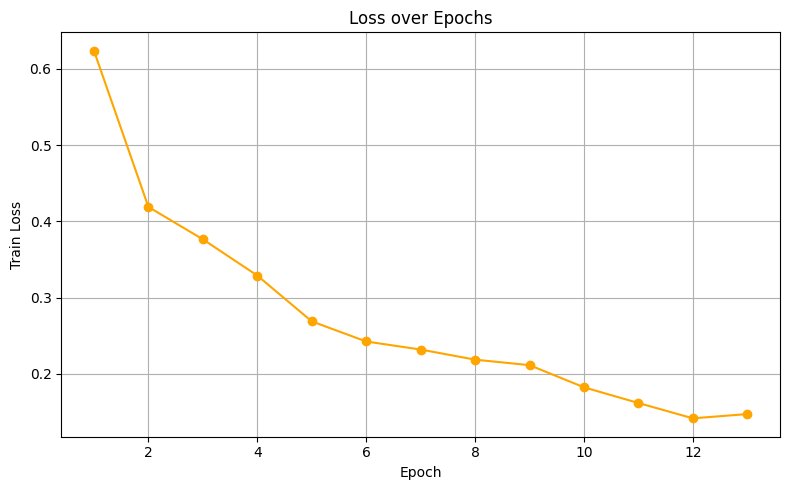

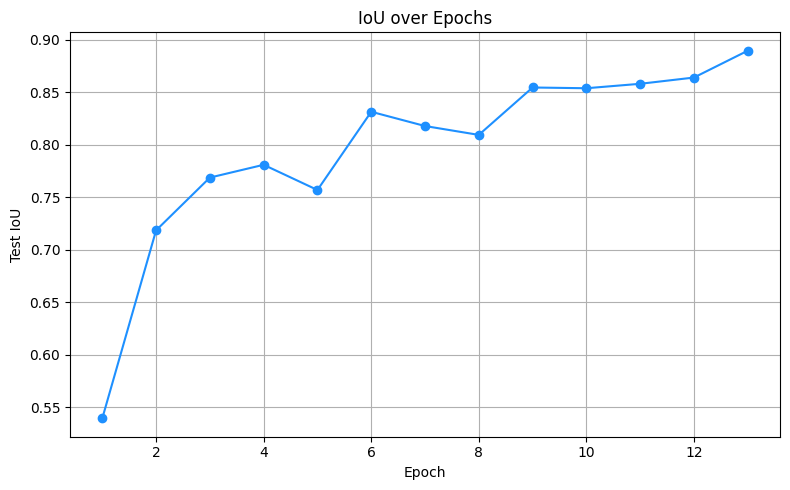

  >> Best model saved at epoch 13 with IoU: 0.8895
[10/95] Loss: 0.1299 Train Acc: 0.9556
[20/95] Loss: 0.1441 Train Acc: 0.9480
[30/95] Loss: 0.1287 Train Acc: 0.9535
[40/95] Loss: 0.1239 Train Acc: 0.9551
[50/95] Loss: 0.1451 Train Acc: 0.9491
[60/95] Loss: 0.1560 Train Acc: 0.9475
[70/95] Loss: 0.1405 Train Acc: 0.9458
[80/95] Loss: 0.1230 Train Acc: 0.9612
[90/95] Loss: 0.1285 Train Acc: 0.9553
Epoch: 14, Test IoU: 0.8557


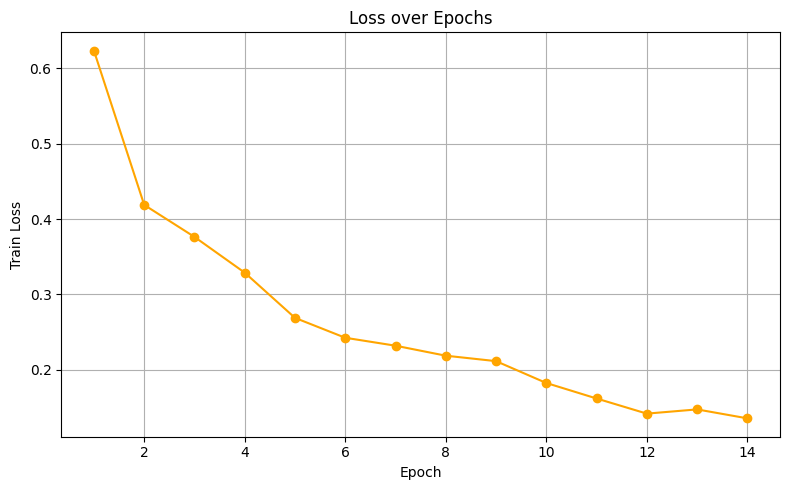

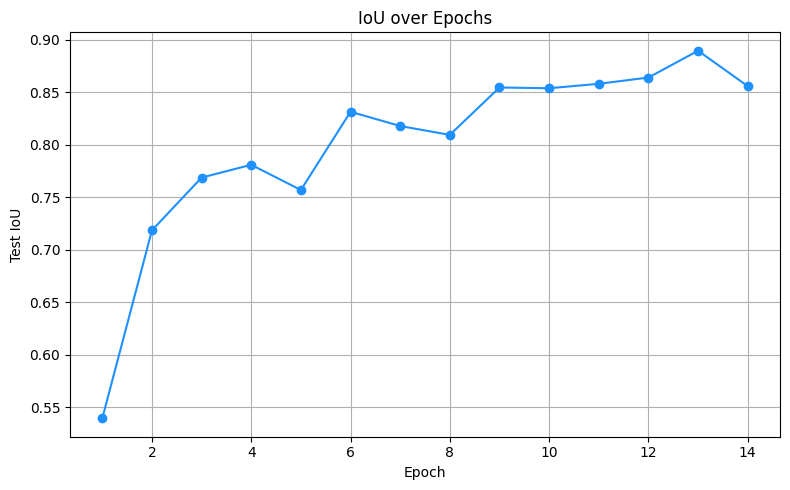

[10/95] Loss: 0.1466 Train Acc: 0.9491
[20/95] Loss: 0.1620 Train Acc: 0.9396
[30/95] Loss: 0.1425 Train Acc: 0.9489
[40/95] Loss: 0.1451 Train Acc: 0.9482
[50/95] Loss: 0.1386 Train Acc: 0.9485
[60/95] Loss: 0.1422 Train Acc: 0.9535
[70/95] Loss: 0.1347 Train Acc: 0.9528
[80/95] Loss: 0.1356 Train Acc: 0.9516
[90/95] Loss: 0.1556 Train Acc: 0.9467
Epoch: 15, Test IoU: 0.8762


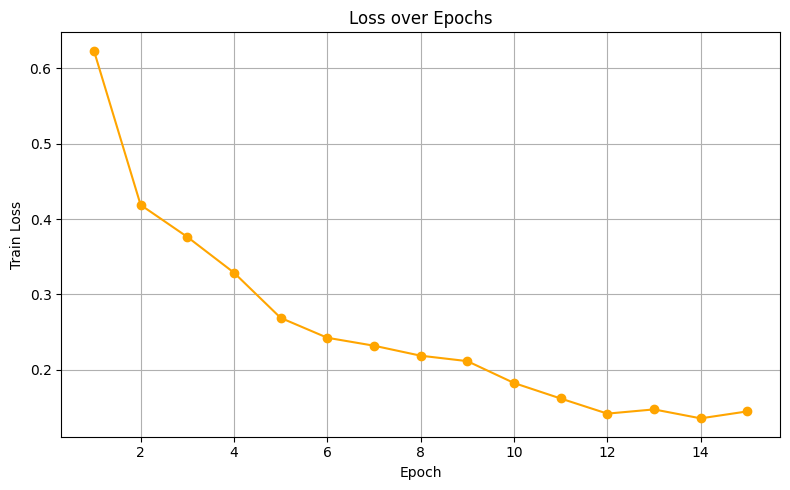

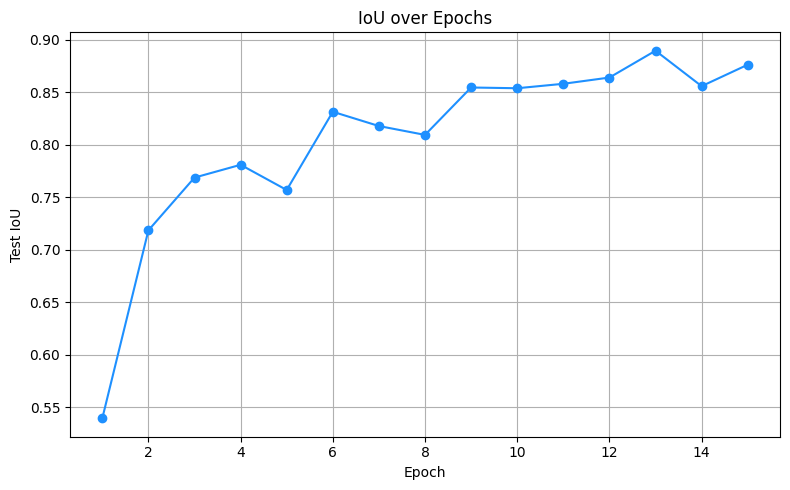

[10/95] Loss: 0.2007 Train Acc: 0.9306
[20/95] Loss: 0.2207 Train Acc: 0.9228
[30/95] Loss: 0.2021 Train Acc: 0.9225
[40/95] Loss: 0.1962 Train Acc: 0.9286
[50/95] Loss: 0.1607 Train Acc: 0.9430
[60/95] Loss: 0.1494 Train Acc: 0.9440
[70/95] Loss: 0.1531 Train Acc: 0.9474
[80/95] Loss: 0.1483 Train Acc: 0.9494
[90/95] Loss: 0.1248 Train Acc: 0.9577
Epoch: 16, Test IoU: 0.8806


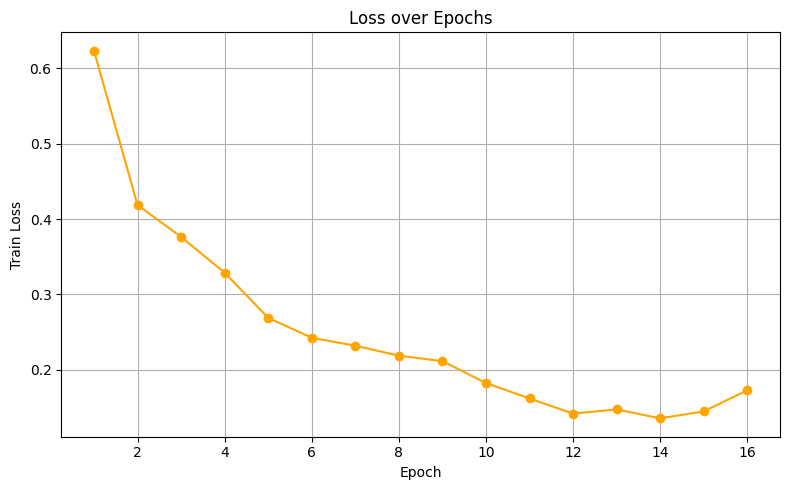

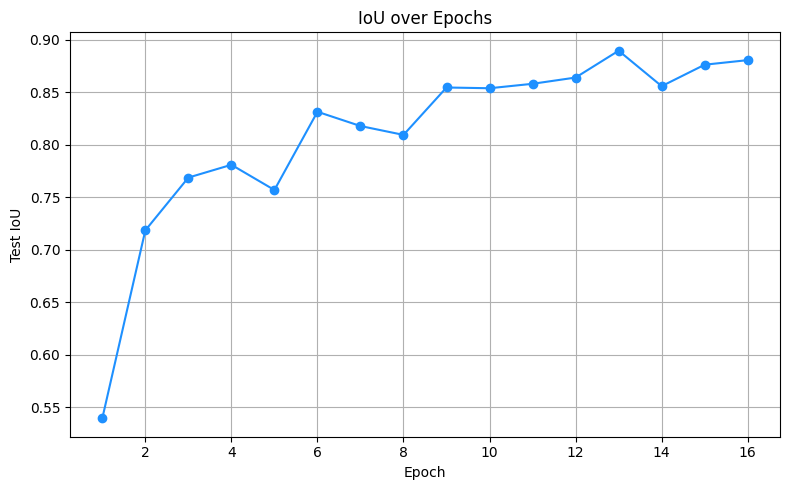

[10/95] Loss: 0.1631 Train Acc: 0.9412
[20/95] Loss: 0.1960 Train Acc: 0.9272
[30/95] Loss: 0.1916 Train Acc: 0.9345
[40/95] Loss: 0.1618 Train Acc: 0.9422
[50/95] Loss: 0.1515 Train Acc: 0.9439
[60/95] Loss: 0.1579 Train Acc: 0.9429
[70/95] Loss: 0.1437 Train Acc: 0.9500
[80/95] Loss: 0.1349 Train Acc: 0.9567
[90/95] Loss: 0.1076 Train Acc: 0.9622
Epoch: 17, Test IoU: 0.8947


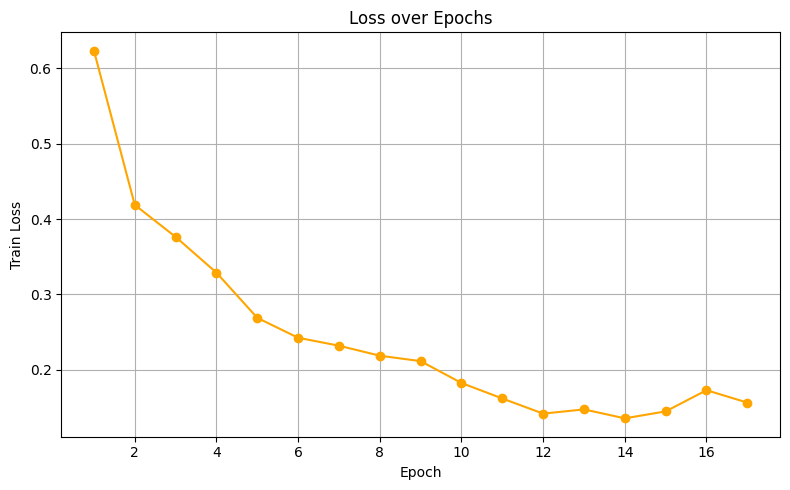

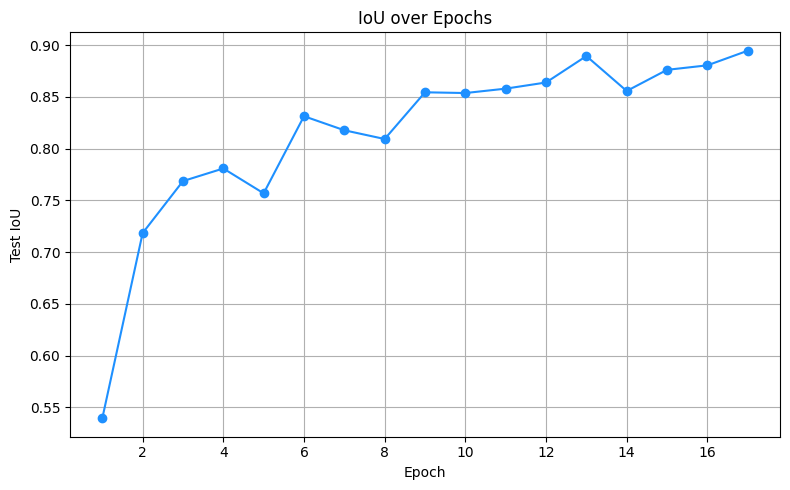

  >> Best model saved at epoch 17 with IoU: 0.8947
[10/95] Loss: 0.1276 Train Acc: 0.9511
[20/95] Loss: 0.1162 Train Acc: 0.9599
[30/95] Loss: 0.1394 Train Acc: 0.9509
[40/95] Loss: 0.1129 Train Acc: 0.9605
[50/95] Loss: 0.1374 Train Acc: 0.9526
[60/95] Loss: 0.1095 Train Acc: 0.9619
[70/95] Loss: 0.1226 Train Acc: 0.9592
[80/95] Loss: 0.1086 Train Acc: 0.9627
[90/95] Loss: 0.1125 Train Acc: 0.9622
Epoch: 18, Test IoU: 0.8858


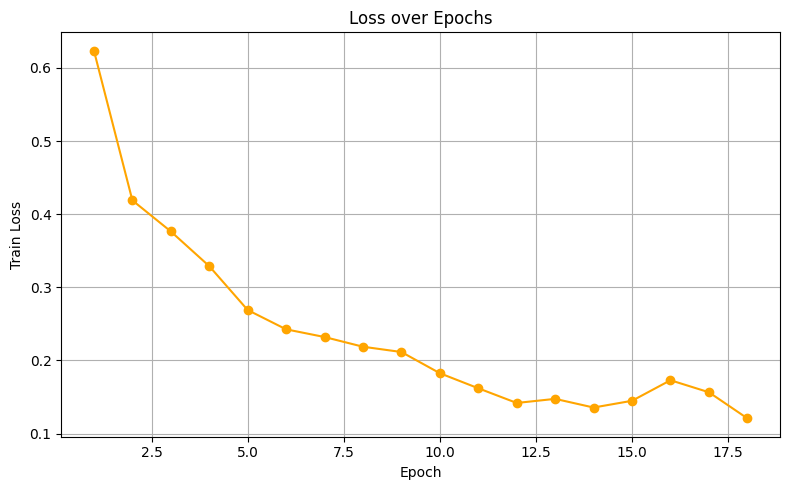

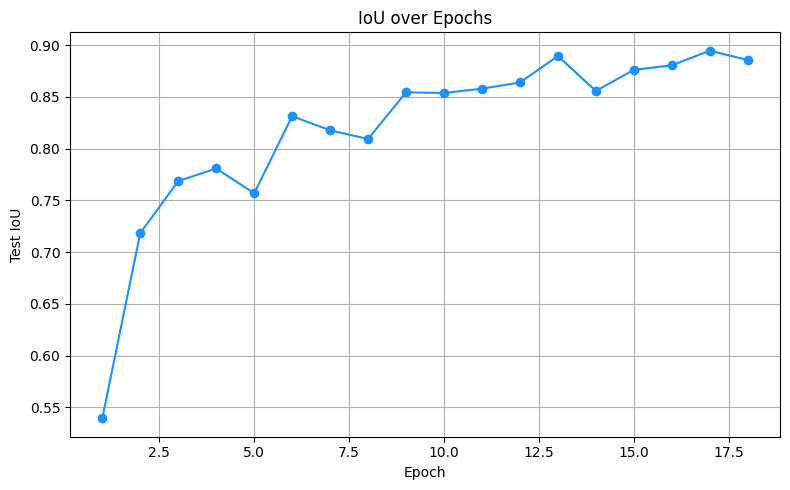

[10/95] Loss: 0.1728 Train Acc: 0.9420
[20/95] Loss: 0.1353 Train Acc: 0.9545
[30/95] Loss: 0.1447 Train Acc: 0.9494
[40/95] Loss: 0.1300 Train Acc: 0.9590
[50/95] Loss: 0.1106 Train Acc: 0.9625
[60/95] Loss: 0.1221 Train Acc: 0.9606
[70/95] Loss: 0.1179 Train Acc: 0.9583
[80/95] Loss: 0.1143 Train Acc: 0.9610
[90/95] Loss: 0.1047 Train Acc: 0.9655
Epoch: 19, Test IoU: 0.9129


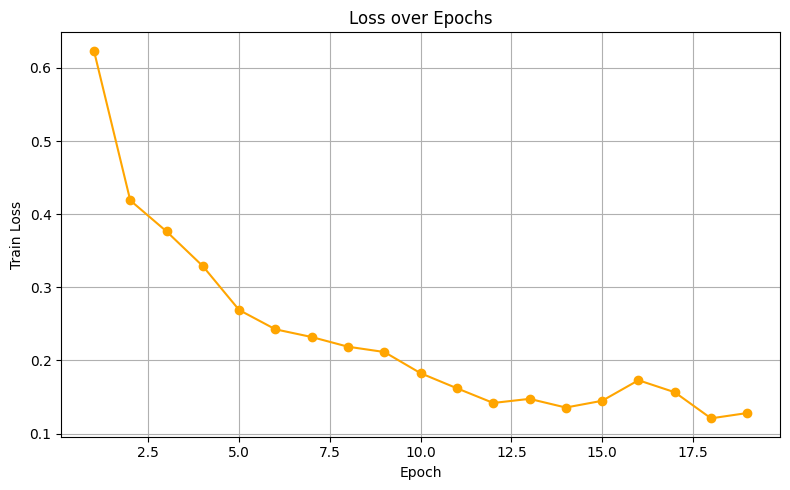

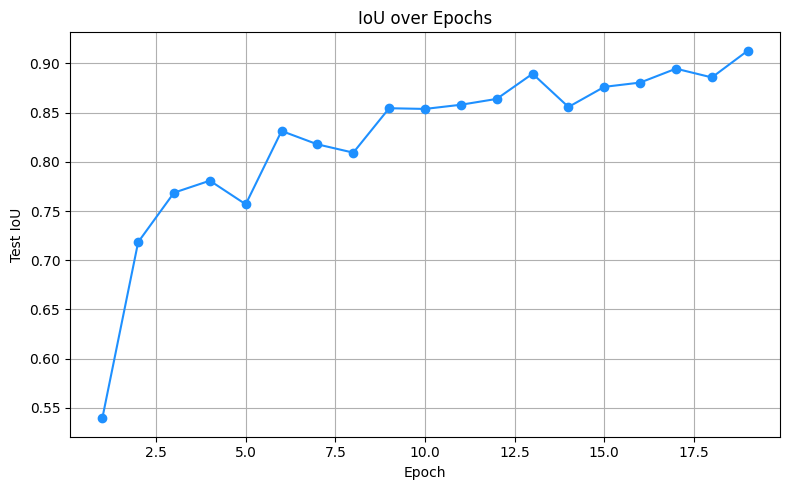

  >> Best model saved at epoch 19 with IoU: 0.9129
[10/95] Loss: 0.0939 Train Acc: 0.9692
[20/95] Loss: 0.1059 Train Acc: 0.9641
[30/95] Loss: 0.1067 Train Acc: 0.9618
[40/95] Loss: 0.1095 Train Acc: 0.9641
[50/95] Loss: 0.0985 Train Acc: 0.9657
[60/95] Loss: 0.0955 Train Acc: 0.9686
[70/95] Loss: 0.0929 Train Acc: 0.9710
[80/95] Loss: 0.1174 Train Acc: 0.9591
[90/95] Loss: 0.0955 Train Acc: 0.9652
Epoch: 20, Test IoU: 0.9067


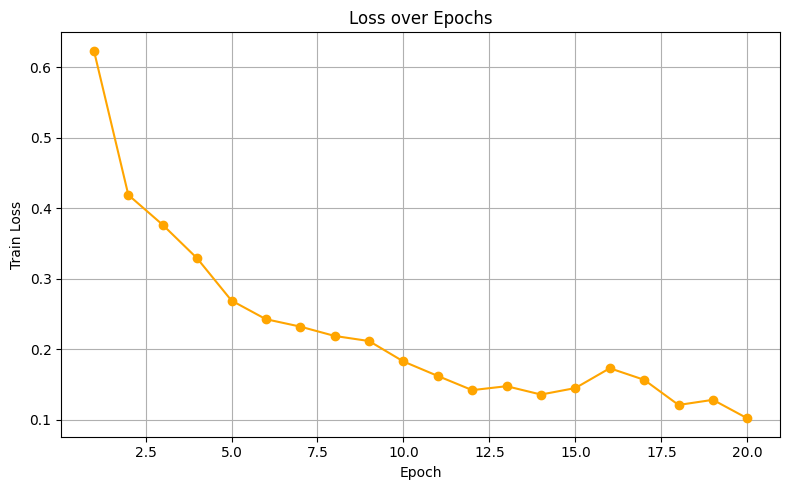

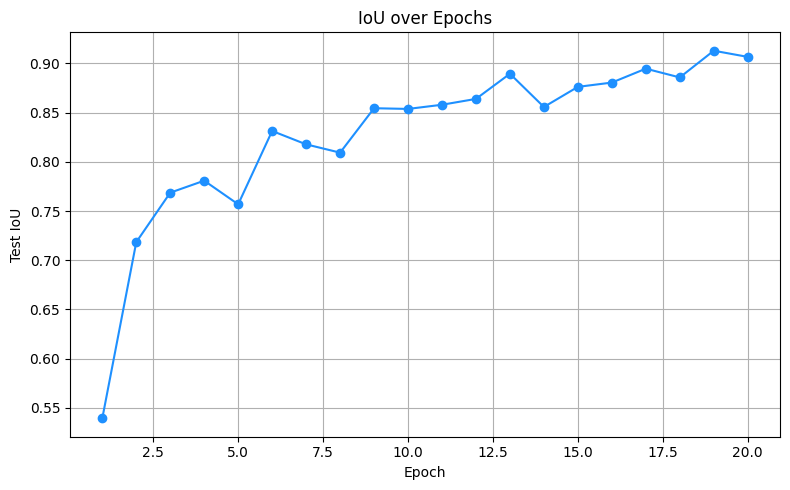

CPU times: user 59min 21s, sys: 10.5 s, total: 59min 31s
Wall time: 1h 4s


In [ ]:
%%time
iou_list = []
loss_list = []

best_iou = 0.0  # or float('-inf') if you're maximizing
best_model_path = "DGCNN_H.pth"

for epoch in range(1, 21):
    loss, acc = train()
    loss_list.append(loss)
    iou = test(test_loader)
    iou_list.append(iou)
    print(f'Epoch: {epoch:02d}, Test IoU: {iou:.4f}')
    plot_loss_over_epochs(loss_list)
    plot_iou_over_epochs(iou_list)
    scheduler.step()
    if iou > best_iou:
        best_iou = iou
        torch.save(model.state_dict(), best_model_path)
        print(f"  >> Best model saved at epoch {epoch} with IoU: {best_iou:.4f}")



[10/95] Loss: 0.0978 Train Acc: 0.9610
[20/95] Loss: 0.0966 Train Acc: 0.9672
[30/95] Loss: 0.0965 Train Acc: 0.9689
[40/95] Loss: 0.0908 Train Acc: 0.9690
[50/95] Loss: 0.1139 Train Acc: 0.9615
[60/95] Loss: 0.0915 Train Acc: 0.9721
[70/95] Loss: 0.0920 Train Acc: 0.9694
[80/95] Loss: 0.0835 Train Acc: 0.9736
[90/95] Loss: 0.0898 Train Acc: 0.9717
Epoch: 01, Test IoU: 0.9075


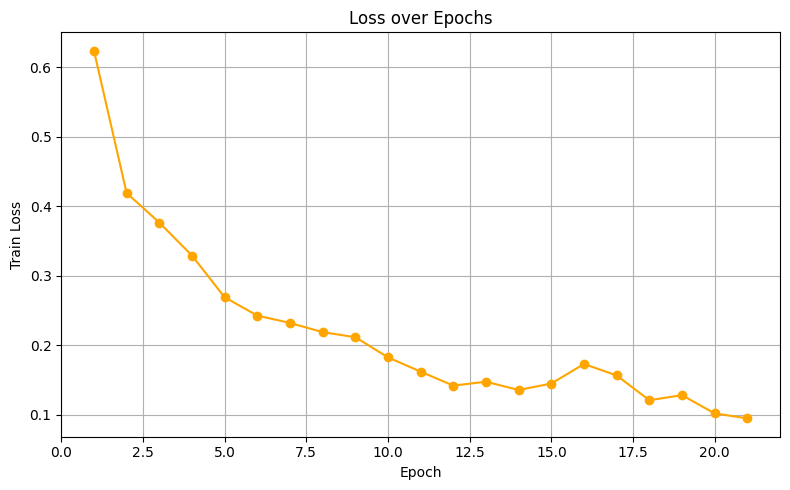

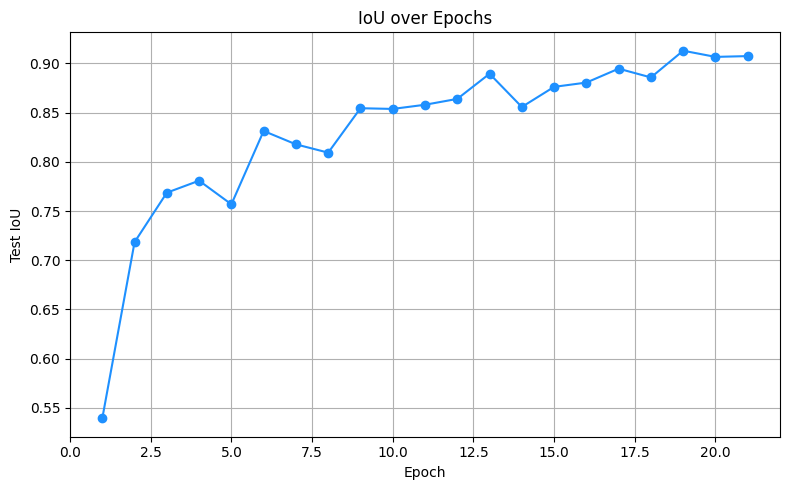

[10/95] Loss: 0.0915 Train Acc: 0.9688
[20/95] Loss: 0.0886 Train Acc: 0.9705
[30/95] Loss: 0.0960 Train Acc: 0.9675
[40/95] Loss: 0.0988 Train Acc: 0.9661
[50/95] Loss: 0.0875 Train Acc: 0.9715
[60/95] Loss: 0.0856 Train Acc: 0.9728
[70/95] Loss: 0.0794 Train Acc: 0.9731
[80/95] Loss: 0.0770 Train Acc: 0.9752
[90/95] Loss: 0.0886 Train Acc: 0.9714
Epoch: 02, Test IoU: 0.9153


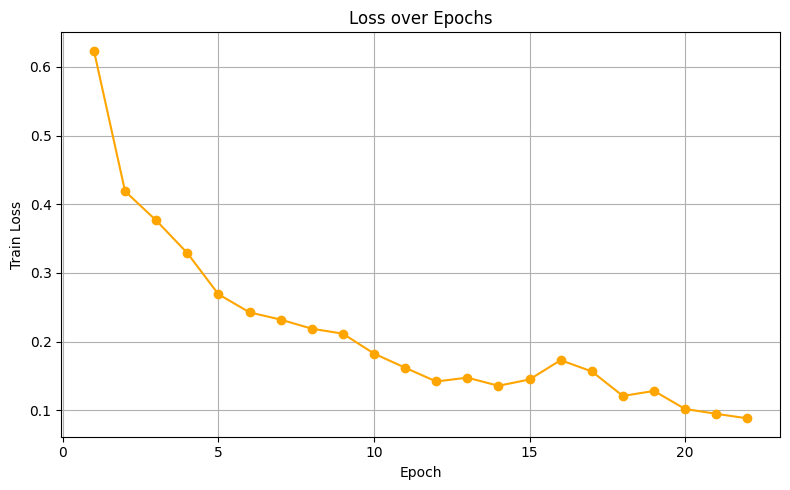

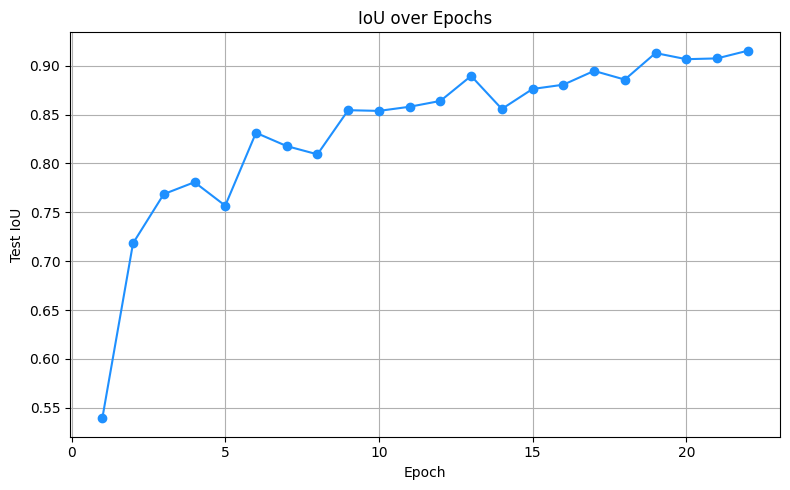

  >> Best model saved at epoch 2 with IoU: 0.9153
[10/95] Loss: 0.1072 Train Acc: 0.9632
[20/95] Loss: 0.1098 Train Acc: 0.9612
[30/95] Loss: 0.1001 Train Acc: 0.9665
[40/95] Loss: 0.0902 Train Acc: 0.9706
[50/95] Loss: 0.0814 Train Acc: 0.9746
[60/95] Loss: 0.0953 Train Acc: 0.9675
[70/95] Loss: 0.0833 Train Acc: 0.9701
[80/95] Loss: 0.0849 Train Acc: 0.9724
[90/95] Loss: 0.0806 Train Acc: 0.9731
Epoch: 03, Test IoU: 0.9239


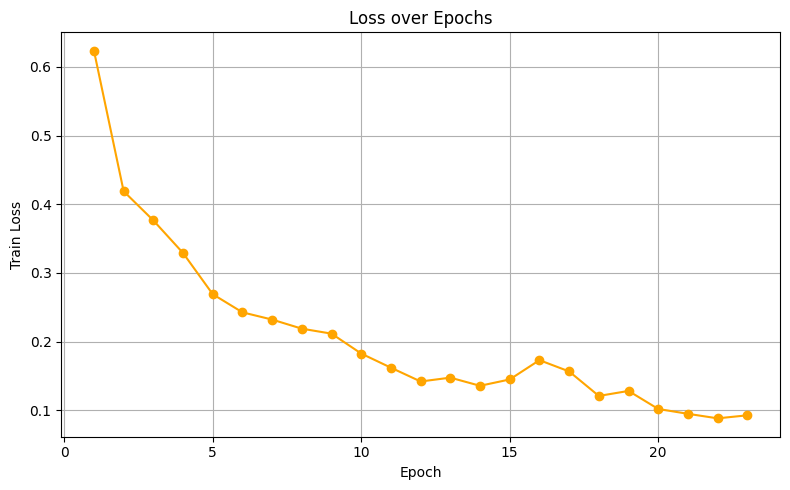

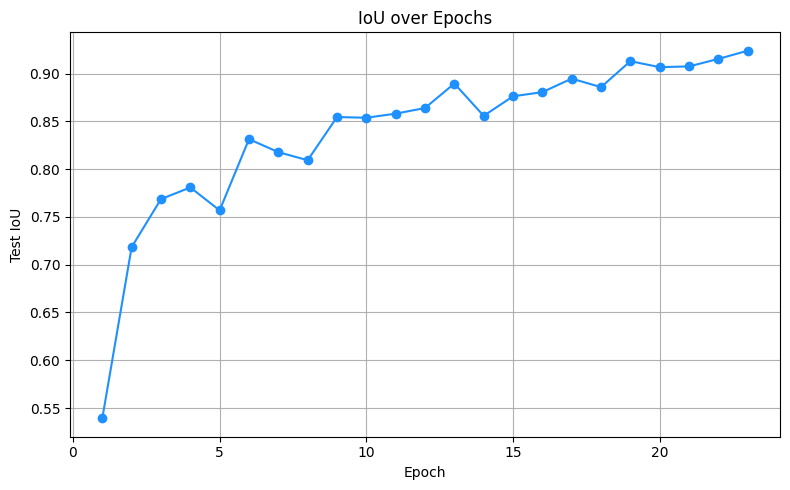

  >> Best model saved at epoch 3 with IoU: 0.9239
[10/95] Loss: 0.0917 Train Acc: 0.9704
[20/95] Loss: 0.0850 Train Acc: 0.9717
[30/95] Loss: 0.0765 Train Acc: 0.9758
[40/95] Loss: 0.0801 Train Acc: 0.9746
[50/95] Loss: 0.0912 Train Acc: 0.9694
[60/95] Loss: 0.0864 Train Acc: 0.9711
[70/95] Loss: 0.0986 Train Acc: 0.9655
[80/95] Loss: 0.0805 Train Acc: 0.9745
[90/95] Loss: 0.0928 Train Acc: 0.9690
Epoch: 04, Test IoU: 0.9132


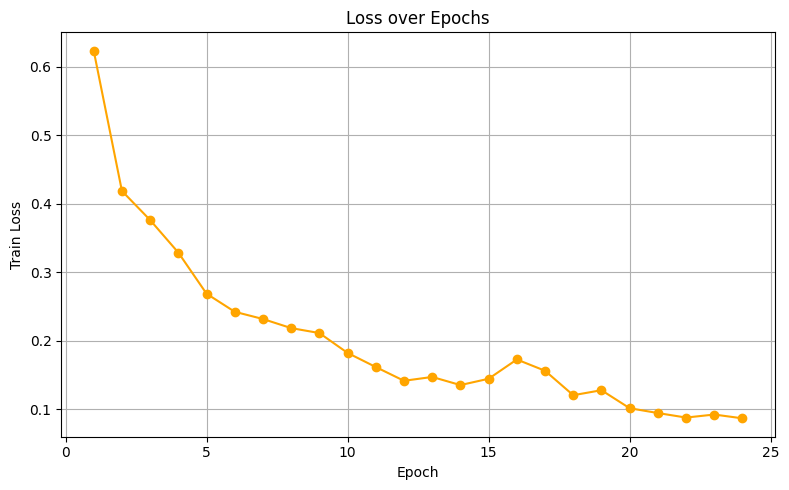

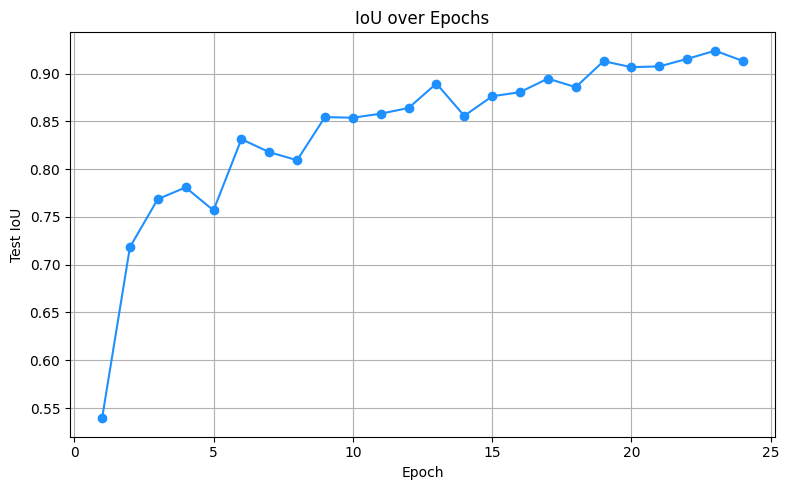

[10/95] Loss: 0.0704 Train Acc: 0.9780
[20/95] Loss: 0.0686 Train Acc: 0.9792
[30/95] Loss: 0.0696 Train Acc: 0.9780
[40/95] Loss: 0.0744 Train Acc: 0.9763
[50/95] Loss: 0.0927 Train Acc: 0.9692
[60/95] Loss: 0.0930 Train Acc: 0.9689
[70/95] Loss: 0.0891 Train Acc: 0.9702
[80/95] Loss: 0.0771 Train Acc: 0.9745
[90/95] Loss: 0.0719 Train Acc: 0.9765
Epoch: 05, Test IoU: 0.9188


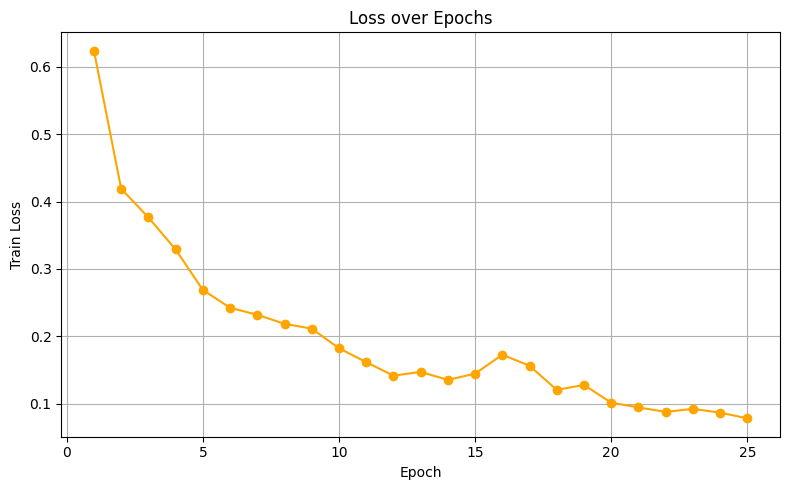

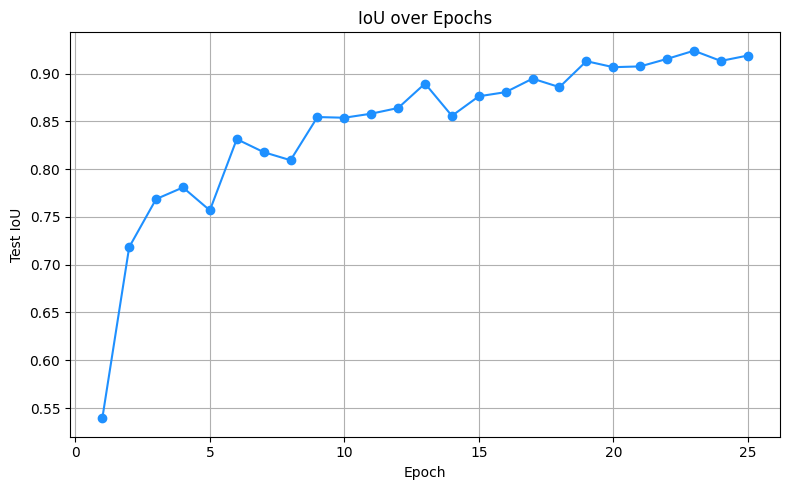

In [ ]:

for epoch in range(1, 6):
    loss, acc = train()
    loss_list.append(loss)
    iou = test(test_loader)
    iou_list.append(iou)
    print(f'Epoch: {epoch:02d}, Test IoU: {iou:.4f}')
    plot_loss_over_epochs(loss_list)
    plot_iou_over_epochs(iou_list)
    scheduler.step()
    if iou > best_iou:
        best_iou = iou
        torch.save(model.state_dict(), best_model_path)
        print(f"  >> Best model saved at epoch {epoch} with IoU: {best_iou:.4f}")

In [ ]:
print(max(iou_list))


0.923888623714447


#Test


In [ ]:
model.load_state_dict(torch.load(best_model_path))

<All keys matched successfully>

In [ ]:
import os
import numpy as np
from pathlib import Path

@torch.no_grad()
def predict_and_save_per_sample(loader, output_dir="break_result"):
    model.eval()
    os.makedirs(output_dir, exist_ok=True)

    y_map = torch.empty(loader.dataset.num_classes, device=device).long()
    idx = 0  # sample index

    for data in loader:
        data = data.to(device)
        outs = model(data)

        sizes = (data.ptr[1:] - data.ptr[:-1]).tolist()
        xs = data.pos.split(sizes)  # assume input is point positions

        ys = data.y.split(sizes)
        categories = data.category.tolist()

        for x, out, y, category in zip(xs, outs.split(sizes), ys, categories):
            category_str = list(BreakBad.seg_classes.keys())[category]
            part = BreakBad.seg_classes[category_str]
            part = torch.tensor(part, device=device)

            y_map[part] = torch.arange(part.size(0), device=device)

            y_pred = out[:, part].argmax(dim=-1)
            y_true = y_map[y]

            # Save as npz
            file_path = Path(output_dir) / f"sample_{idx:04d}.npz"
            np.savez_compressed(
                file_path,
                x=x.cpu().numpy(),             # 3D points
                y_true=y_true.cpu().numpy(),   # ground truth labels
                y_pred=y_pred.cpu().numpy()    # predicted labels
            )
            idx += 1

    print(f"Saved {idx} samples to: {output_dir}")
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401


gt_cmap = np.array([
    [0.121, 0.466, 0.705],  # Blue for class 0
    [1.000, 0.498, 0.054],  # Orange for class 1
])
pred_cmap = np.array([
    [0.054, 0.705, 0.054],  # Blue
    [1.000, 0.498, 0.054],  # Orange
])

def visualize_sample_npz(file_path):
    data = np.load(file_path)
    x = data['x']           # shape: (N, 3)
    y_true = data['y_true'] # shape: (N,)
    print(np.unique(y_true))
    y_pred = data['y_pred'] # shape: (N,)
    print(np.unique(y_pred))

    gt_colors = gt_cmap[y_true]
    pred_colors = pred_cmap[y_pred]

    fig = plt.figure(figsize=(12, 6))

    # --- Ground Truth ---
    ax1 = fig.add_subplot(1, 2, 1, projection='3d')
    ax1.scatter(x[:, 0], x[:, 1], x[:, 2], c=gt_colors, s=5)
    ax1.set_title("Ground Truth Labels")
    ax1.axis('off')

    # --- Prediction ---
    ax2 = fig.add_subplot(1, 2, 2, projection='3d')
    ax2.scatter(x[:, 0], x[:, 1], x[:, 2], c=pred_colors, s=5)
    ax2.set_title("Predicted Labels")
    ax2.axis('off')

    plt.tight_layout()
    plt.show()




In [ ]:

@torch.no_grad()
def eval_value(loader):
    model.eval()

    ious, categories = [], []
    correct, total = 0, 0  # For accuracy
    y_map = torch.empty(loader.dataset.num_classes, device=device).long()

    for data in loader:
        data = data.to(device)
        outs = model(data)

        sizes = (data.ptr[1:] - data.ptr[:-1]).tolist()
        for out, y, category in zip(outs.split(sizes), data.y.split(sizes),
                                    data.category.tolist()):
            category = list(BreakBad.seg_classes.keys())[category]
            part = BreakBad.seg_classes[category]
            part = torch.tensor(part, device=device)

            y_map[part] = torch.arange(part.size(0), device=device)

            pred = out[:, part].argmax(dim=-1)
            target = y_map[y]

            correct += (pred == target).sum().item()
            total += target.numel()

            iou = jaccard_index(pred, target,
                                num_classes=part.size(0), absent_score=1.0)
            ious.append(iou)

        categories.append(data.category)

    iou = torch.tensor(ious, device=device)
    category = torch.cat(categories, dim=0)

    mean_iou = scatter(iou, category, reduce='mean')  # Per-category IoU.
    accuracy = correct / total

    return accuracy, float(mean_iou.mean())  # Return both Accuracy and Mean IoU

In [ ]:
acc, miou = eval_value(test_loader)
print(f"Accuracy: {acc:.4f}, Mean IoU: {miou:.4f}")

Accuracy: 0.9673, Mean IoU: 0.9154


In [ ]:
predict_and_save_per_sample(test_loader)

Saved 283 samples to: break_result


Sample_0132.npz
[0 1]
[0 1]


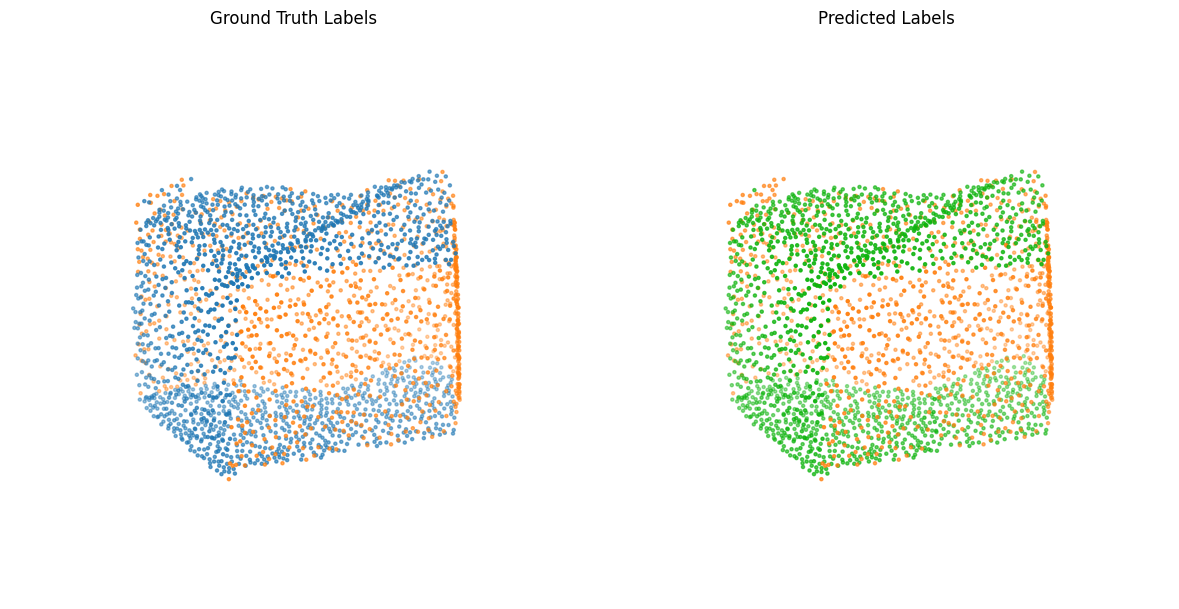

In [ ]:
idx = random.randint(0, 266 )
print(f"Sample_{idx:04d}.npz")
visualize_sample_npz(f"/content/break_result/sample_{idx:04d}.npz")

#fanta


In [ ]:
!rm -r /content/data2

In [ ]:
!unzip /content/processed_fanta_v4.zip -d /content/temp_extract
!mkdir /content/data2
!mkdir /content/data2/raw
!mv /content/temp_extract/processed_fanta_v4/* /content/data2/raw
!rm -r /content/temp_extract

Archive:  /content/processed_fanta_v4.zip
   creating: /content/temp_extract/processed_fanta_v4/
   creating: /content/temp_extract/processed_fanta_v4/abc/
  inflating: /content/temp_extract/processed_fanta_v4/abc/00002.txt  
  inflating: /content/temp_extract/processed_fanta_v4/abc/00003.txt  
  inflating: /content/temp_extract/processed_fanta_v4/abc/00005.txt  
  inflating: /content/temp_extract/processed_fanta_v4/abc/00006.txt  
  inflating: /content/temp_extract/processed_fanta_v4/abc/00008.txt  
  inflating: /content/temp_extract/processed_fanta_v4/abc/00011.txt  
  inflating: /content/temp_extract/processed_fanta_v4/abc/00012.txt  
  inflating: /content/temp_extract/processed_fanta_v4/abc/00013.txt  
  inflating: /content/temp_extract/processed_fanta_v4/abc/00014.txt  
  inflating: /content/temp_extract/processed_fanta_v4/abc/00015.txt  
  inflating: /content/temp_extract/processed_fanta_v4/abc/00016.txt  
  inflating: /content/temp_extract/processed_fanta_v4/abc/00017.txt  
  in

In [ ]:

class FantaBrk(InMemoryDataset):
    r"""The ShapeNet part level segmentation dataset from the `"A Scalable
    Active Framework for Region Annotation in 3D Shape Collections"
    <http://web.stanford.edu/~ericyi/papers/part_annotation_16_small.pdf>`_
    paper, containing about 17,000 3D shape point clouds from 16 shape
    categories.
    Each category is annotated with 2 to 6 parts.

    Args:
        root (str): Root directory where the dataset should be saved.
        categories (str or [str], optional): The category of the CAD models
            (one or a combination of :obj:`"Airplane"`, :obj:`"Bag"`,
            :obj:`"Cap"`, :obj:`"Car"`, :obj:`"Chair"`, :obj:`"Earphone"`,
            :obj:`"Guitar"`, :obj:`"Knife"`, :obj:`"Lamp"`, :obj:`"Laptop"`,
            :obj:`"Motorbike"`, :obj:`"Mug"`, :obj:`"Pistol"`, :obj:`"Rocket"`,
            :obj:`"Skateboard"`, :obj:`"Table"`).
            Can be explicitly set to :obj:`None` to load all categories.
            (default: :obj:`None`)
        include_normals (bool, optional): If set to :obj:`False`, will not
            include normal vectors as input features to :obj:`data.x`.
            As a result, :obj:`data.x` will be :obj:`None`.
            (default: :obj:`True`)
        split (str, optional): If :obj:`"train"`, loads the training dataset.
            If :obj:`"val"`, loads the validation dataset.
            If :obj:`"trainval"`, loads the training and validation dataset.
            If :obj:`"test"`, loads the test dataset.
            (default: :obj:`"trainval"`)
        transform (callable, optional): A function/transform that takes in an
            :obj:`torch_geometric.data.Data` object and returns a transformed
            version. The data object will be transformed before every access.
            (default: :obj:`None`)
        pre_transform (callable, optional): A function/transform that takes in
            an :obj:`torch_geometric.data.Data` object and returns a
            transformed version. The data object will be transformed before
            being saved to disk. (default: :obj:`None`)
        pre_filter (callable, optional): A function that takes in an
            :obj:`torch_geometric.data.Data` object and returns a boolean
            value, indicating whether the data object should be included in the
            final dataset. (default: :obj:`None`)
        force_reload (bool, optional): Whether to re-process the dataset.
            (default: :obj:`False`)

    **STATS:**

    .. list-table::
        :widths: 10 10 10 10 10
        :header-rows: 1

        * - #graphs
          - #nodes
          - #edges
          - #features
          - #classes
        * - 16,881
          - ~2,616.2
          - 0
          - 3
          - 50
    """

    url = ('https://shapenet.cs.stanford.edu/media/'
           'shapenetcore_partanno_segmentation_benchmark_v0_normal.zip')

    # In case `shapenet.cs.stanford.edu` is offline, try to download the data
    # from Kaggle instead (requires login):
    # https://www.kaggle.com/datasets/mitkir/shapenet/download?datasetVersionNumber=1

    category_ids = {'All_Statue': 'abc'}



    seg_classes = {'All_Statue': [0, 1]}

    def __init__(
        self,
        root: str,
        categories: Optional[Union[str, List[str]]] = None,
        include_normals: bool = True,
        split: str = 'trainval',
        transform: Optional[Callable] = None,
        pre_transform: Optional[Callable] = None,
        pre_filter: Optional[Callable] = None,
        force_reload: bool = False,
    ) -> None:
        if categories is None:
            categories = list(self.category_ids.keys())
        if isinstance(categories, str):
            categories = [categories]
        print(categories)
        assert all(category in self.category_ids for category in categories)
        self.categories = categories
        super().__init__(root, transform, pre_transform, pre_filter,
                         force_reload=force_reload)

        if split == 'train':
            path = self.processed_paths[0]
        elif split == 'val':
            path = self.processed_paths[1]
        elif split == 'test':
            path = self.processed_paths[2]
        elif split == 'trainval':
            path = self.processed_paths[3]
        else:
            raise ValueError(f'Split {split} found, but expected either '
                             'train, val, trainval or test')

        self.load(path)

        assert isinstance(self._data, Data)
        self._data.x = self._data.x if include_normals else None

        self.y_mask = torch.zeros((len(self.seg_classes.keys()),len(self.seg_classes.keys())*2),
                                  dtype=torch.bool)
        for i, labels in enumerate(self.seg_classes.values()):
            self.y_mask[i, labels] = 1

    @property
    def num_classes(self) -> int:
        return self.y_mask.size(-1)

    @property
    def raw_file_names(self) -> List[str]:
        return list(self.category_ids.values()) + ['train_test_split']

    @property
    def processed_file_names(self) -> List[str]:
        cats = '_'.join([cat[:3].lower() for cat in self.categories])
        return [
            osp.join(f'{cats}_{split}.pt')
            for split in ['train', 'val', 'test', 'trainval']
        ]

    def download(self) -> None:
        pass

    def process_filenames(self, filenames: List[str]) -> List[Data]:
        rank_ids = {'abc': 0}
        data_list = []
        categories_ids = [self.category_ids[cat] for cat in self.categories]
        cat_idx = {categories_ids[i]: i for i in range(len(categories_ids))}

        for name in filenames:
            cat = name.split(osp.sep)[0]
            if cat not in categories_ids:
                continue
            my_custom_idx = rank_ids[cat]
            tensor = read_txt_array(osp.join(self.raw_dir, name))
            pos = tensor[:, :3]
            x = tensor[:, 3:6]
            y = tensor[:, -1].type(torch.long)+2*my_custom_idx
            data = Data(pos=pos, x=x, y=y, category=cat_idx[cat])
            if self.pre_filter is not None and not self.pre_filter(data):
                continue
            if self.pre_transform is not None:
                data = self.pre_transform(data)
            data_list.append(data)

        return data_list

    def process(self) -> None:
        trainval = []
        for i, split in enumerate(['train', 'val', 'test']):
            path = osp.join(self.raw_dir, 'train_test_split',
                            f'shuffled_{split}_file_list.json')
            with open(path) as f:
                filenames = [
                    osp.sep.join(name.split('/')[1:]) + '.txt'
                    for name in json.load(f)
                ]  # Removing first directory.
            data_list = self.process_filenames(filenames)
            if split == 'train' or split == 'val':
                trainval += data_list
            self.save(data_list, self.processed_paths[i])
        self.save(trainval, self.processed_paths[3])

    def __repr__(self) -> str:
        return (f'{self.__class__.__name__}({len(self)}, '
                f'categories={self.categories})')


In [ ]:
category = None  # Pass in `None` to train on all categories.
path = "/content/data2"
transform = T.Compose([
    T.RandomJitter(0.01),
    T.RandomRotate(15, axis=0),
    T.RandomRotate(15, axis=1),
    T.RandomRotate(15, axis=2)
])
pre_transform = T.NormalizeScale()
train_dataset2 = FantaBrk(path, category, split='trainval', transform=transform,
                         pre_transform=pre_transform)
test_dataset2 = FantaBrk(path, category, split='test',
                        pre_transform=pre_transform)
train_loader2 = DataLoader(train_dataset2, batch_size=12, shuffle=True,
                          num_workers=2)
test_loader2 = DataLoader(test_dataset2, batch_size=12, shuffle=False,
                         num_workers=2)

['All_Statue']


Processing...


['All_Statue']


Done!


Unique classes [0 1]


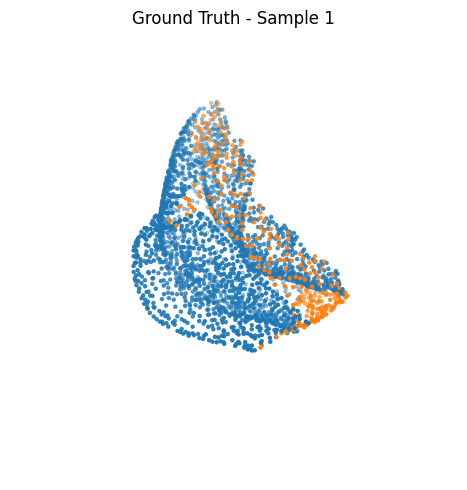

Unique classes [0 1]


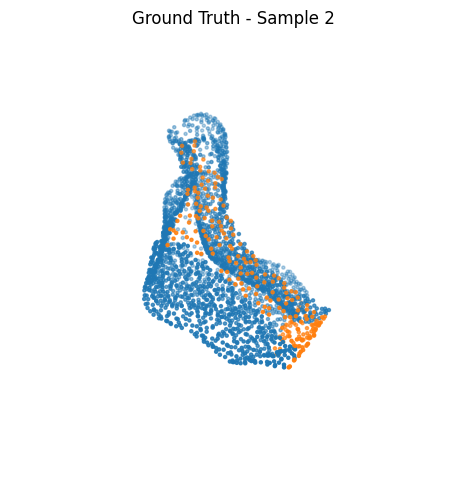

Unique classes [0 1]


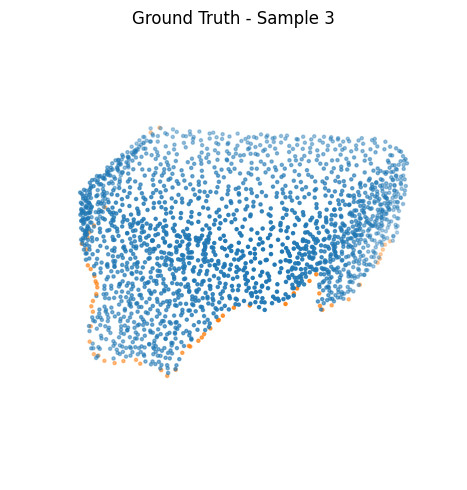

Unique classes [0 1]


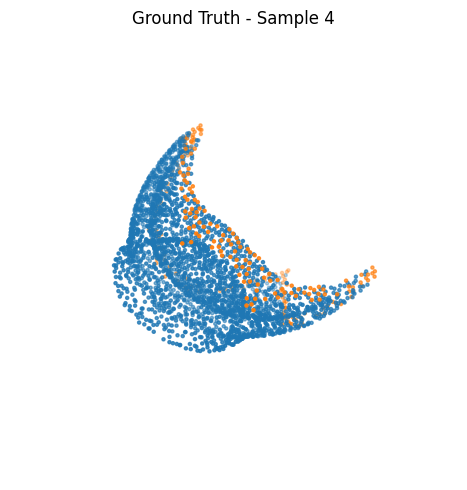

In [ ]:
visualize_ground_truth_3d(test_loader2, num_samples=4)

In [ ]:
import torch

@torch.no_grad()
def eval_value_unseen(loader):
    model.eval()

    ious = []
    correct, total = 0, 0

    for data in loader:
        data = data.to(device)
        out = model(data)  # Shape: [num_points, num_classes]

        # Predict across ALL classes
        pred = out.argmax(dim=-1)%2
        # print(pred)
        target = data.y

        # Accuracy
        correct += (pred == target).sum().item()
        total += target.numel()

        # IoU (mean across classes in this sample)
        iou = jaccard_index(pred, target,num_classes=2, absent_score=1.0)
        ious.append(iou)

    accuracy = correct / total
    mean_iou = np.mean(ious)

    return accuracy, mean_iou, ious


In [ ]:

@torch.no_grad()
def predict_and_save_per_sample_unseen(loader, output_dir="break_result"):
    model.eval()
    os.makedirs(output_dir, exist_ok=True)

    idx = 0  # sample index

    for data in loader:
        data = data.to(device)
        outs = model(data)  # shape: [num_points, num_classes]

        sizes = (data.ptr[1:] - data.ptr[:-1]).tolist()
        xs = data.pos.split(sizes)   # point positions
        ys = data.y.split(sizes)     # ground truth labels
        outs_split = outs.split(sizes)

        for x, out, y in zip(xs, outs_split, ys):
            y_pred = out.argmax(dim=-1)%2  # predict across all classes
            y_true = y                   # keep original labels

            # Save as npz
            file_path = Path(output_dir) / f"sample_{idx:04d}.npz"
            np.savez_compressed(
                file_path,
                x=x.cpu().numpy(),             # 3D points
                y_true=y_true.cpu().numpy(),   # ground truth labels
                y_pred=y_pred.cpu().numpy()    # predicted labels
            )
            idx += 1

    print(f"Saved {idx} samples to: {output_dir}")

In [ ]:
acc, miou, test = eval_value_unseen(train_loader2)
print(f"Accuracy: {acc:.4f}, Mean IoU: {miou:.4f}")

Accuracy: 0.9404, Mean IoU: 0.5514


In [ ]:
length = predict_and_save_per_sample_unseen(train_loader2,output_dir = "fanta_result")

Saved 120 samples to: fanta_result


Sample_0089.npz
[0 1]
[0 1]


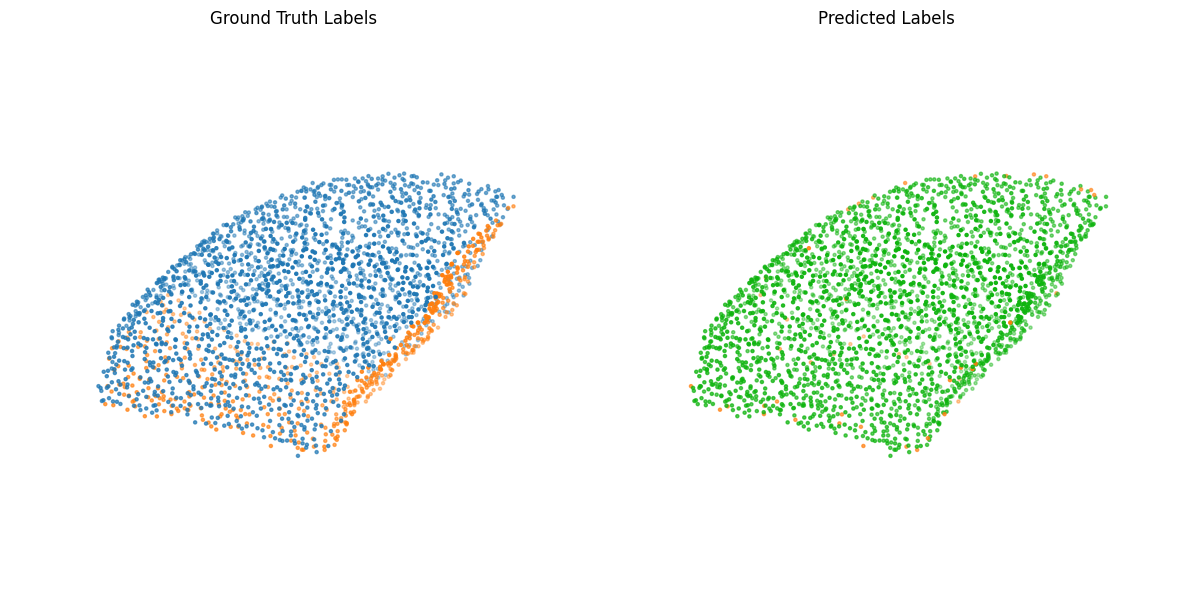

Sample_0048.npz
[0 1]
[0 1]


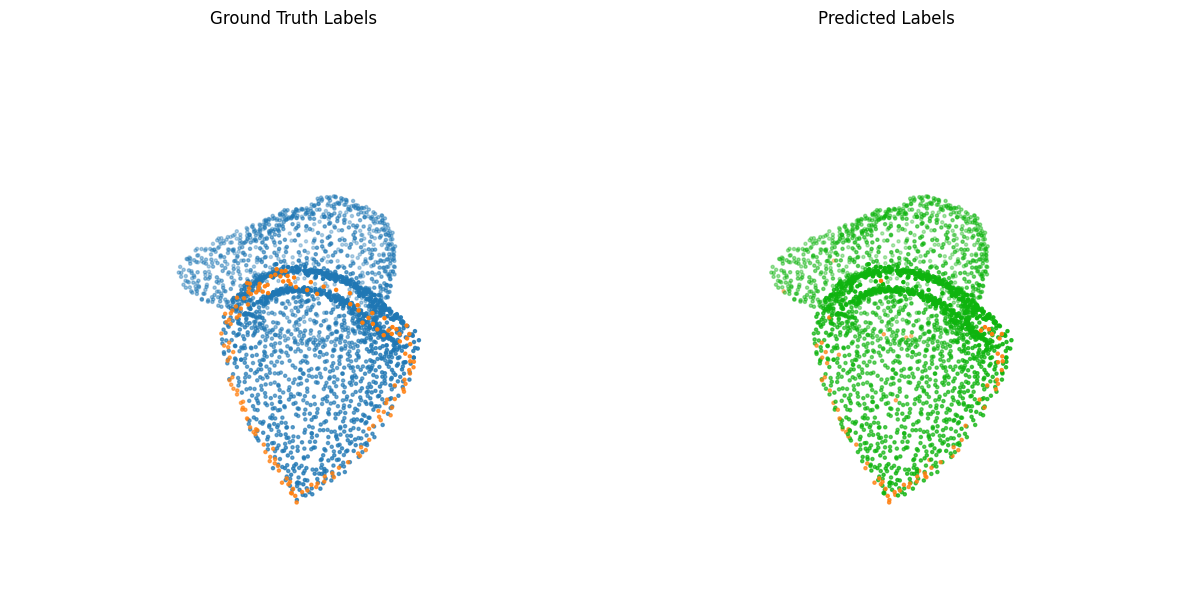

Sample_0051.npz
[0 1]
[0 1]


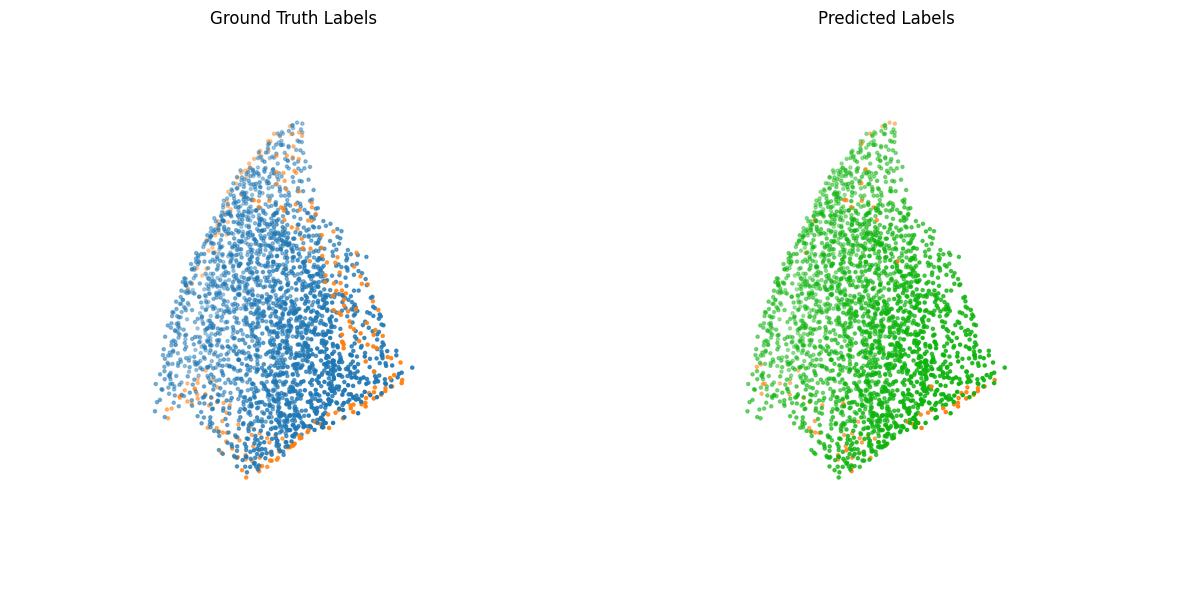

Sample_0070.npz
[0 1]
[0 1]


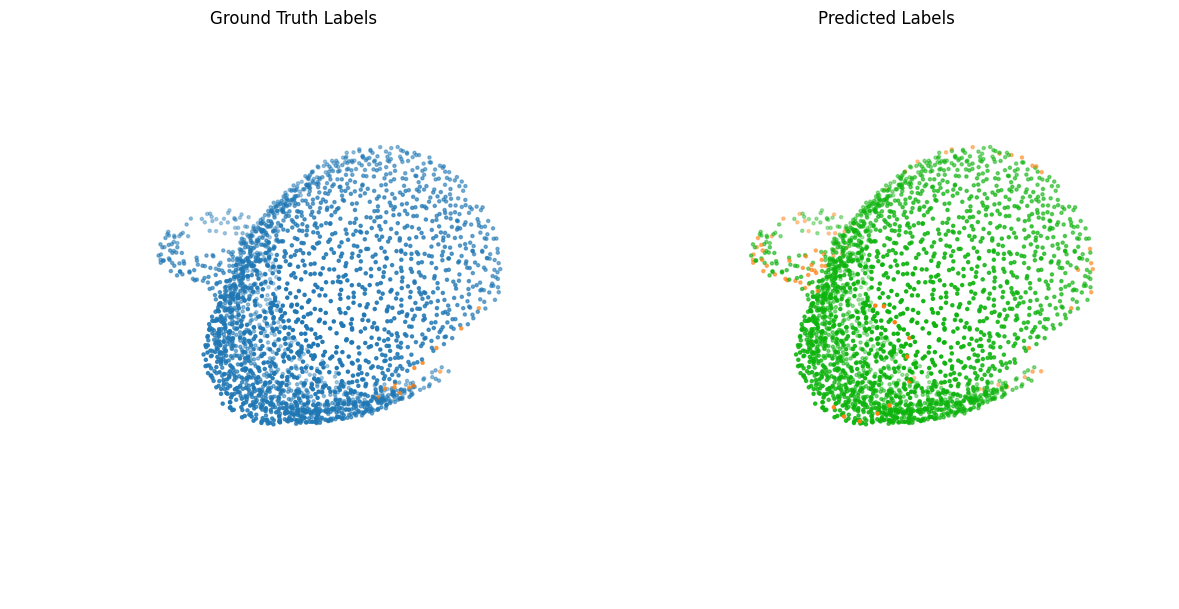

Sample_0108.npz
[0 1]
[0 1]


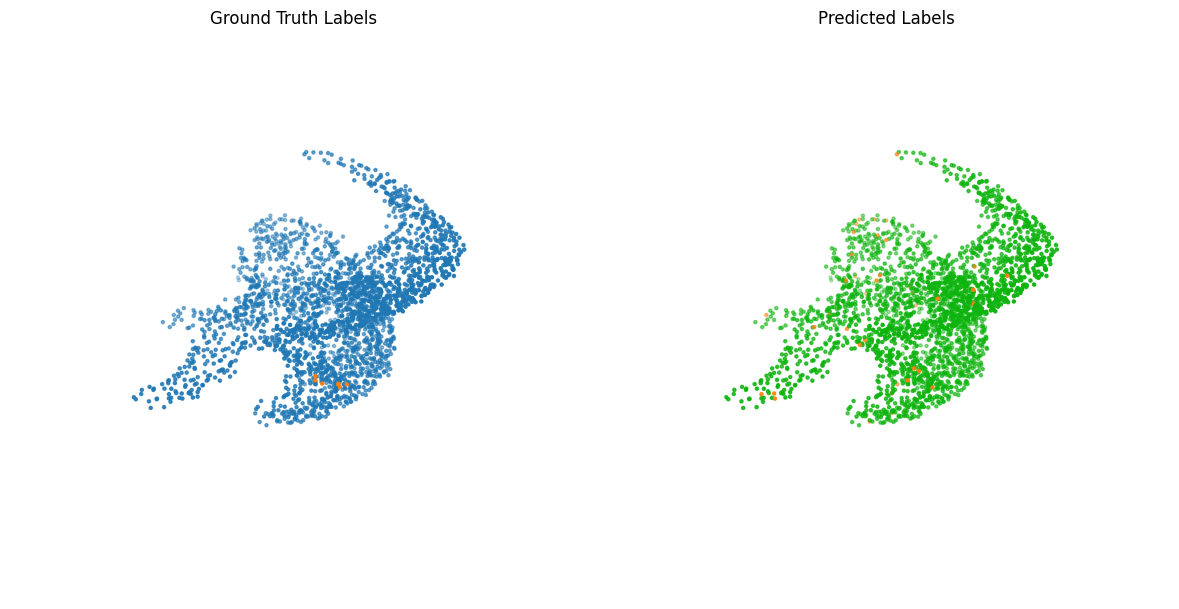

In [ ]:
def wow2():
  idx = random.randint(0, 120)
  print(f"Sample_{idx:04d}.npz")
  visualize_sample_npz(f"/content/fanta_result/sample_{idx:04d}.npz")

wow2()

wow2()

wow2()
wow2()

wow2()

In [ ]:
!mkdir -p output
!cp -r /content/break_result output/
!cp -r /content/fanta_result output/
!cp /content/DGCNN_H.pth output/
!zip -r DGCNN_H.zip output

from google.colab import files
files.download("DGCNN_H.zip")

  adding: output/ (stored 0%)
  adding: output/break_result/ (stored 0%)
  adding: output/break_result/sample_0248.npz (deflated 0%)
  adding: output/break_result/sample_0140.npz (deflated 1%)
  adding: output/break_result/sample_0051.npz (deflated 0%)
  adding: output/break_result/sample_0009.npz (deflated 0%)
  adding: output/break_result/sample_0203.npz (deflated 0%)
  adding: output/break_result/sample_0006.npz (deflated 0%)
  adding: output/break_result/sample_0184.npz (deflated 1%)
  adding: output/break_result/sample_0110.npz (deflated 0%)
  adding: output/break_result/sample_0127.npz (deflated 1%)
  adding: output/break_result/sample_0279.npz (deflated 0%)
  adding: output/break_result/sample_0216.npz (deflated 0%)
  adding: output/break_result/sample_0230.npz (deflated 0%)
  adding: output/break_result/sample_0187.npz (deflated 0%)
  adding: output/break_result/sample_0123.npz (deflated 0%)
  adding: output/break_result/sample_0221.npz (deflated 0%)
  adding: output/break_resu

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>